In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import sys
import importlib
import scipy as sci

sys.path.append(".")

import pickle
import autogenes

from scvelo.plotting.utils import is_categorical, interpret_colorkey, savefig_or_show
import matplotlib.pyplot as plt

data_file = './EthSin/'

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
#select replicate indices and save their sum
def removeReplicas(adata):
    #find genes with a '.' in their name
    noreplica = adata.var.loc[~adata.var.index.str.contains("\\."),:].index
    print(adata[:,noreplica])
    replicas = adata.var.loc[adata.var.index.str.contains("\\."),:].index
    uniques = set()
    new_var_names = set()
    for x in replicas: 
        uniques.add(x.split(".")[0])
        new_var_names.add(x.split(".")[0])
    new_var_names.update(noreplica.tolist())
    adata_new = sc.AnnData(np.zeros((len(adata.obs_names),len(new_var_names))))
    adata_new.var_names = list(new_var_names)
    adata_new.obs_names = adata.obs_names
    adata_new[:,noreplica].X = adata[:,noreplica].X
    adata_new.obs = adata.obs
    for x in uniques:
        ind = adata.var.loc[adata.var.index.str.contains(x),:].index
        if(len(ind)!=1):
            adata_new[:,x].X = np.sum(adata[:,ind].X,axis=1)
        else:
            adata_new[:,x].X =  adata[:,ind[0]].X
    return adata_new

In [3]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.colors import ColorConverter
import pandas as pd
from pandas import unique, isnull
from scipy.sparse import issparse
from scvelo.plotting.utils import is_categorical, interpret_colorkey, savefig_or_show


def heatmap(adata, var_names, tkey='pseudotime', xkey='Ms', color_map='magma', col_color=None, n_convolve=30,
            standard_scale=0, sort=True, colorbar=None, col_cluster=False, row_cluster=False, figsize=(10, 5),
            font_scale=None, show=True, save=None, ax=None, dpi=200, **kwargs):
    """\
    Plot time series for genes as heatmap.
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names: `str`,  list of `str`
        Names of variables to use for the plot.
    tkey: `str` (default: `'pseudotime'`)
        Observation key to extract time data from.
    xkey: `str` (default: `'Ms'`)
        Layer key to extract count data from.
    color_map: `str` (default: `'viridis'`)
        String denoting matplotlib color map.
    col_color: `str` or `None` (default: `None`)
        String denoting matplotlib color map to use along the columns.
    n_convolve: `int` or `None` (default: `30`)
        If `int` is given, data is smoothed by convolution along the x-axis with kernel size n_convolve.
    standard_scale : `int` or `None` (default: `0`)
        Either 0 (rows) or 1 (columns). Whether or not to standardize that dimension, meaning for each row or column,
        subtract the minimum and divide each by its maximum.
    sort: `bool` (default: `True`)
        Wether to sort the expression values given by xkey.
    colorbar: `bool` or `None` (default: `None`)
        Whether to show colorbar.
    {row,col}_cluster : bool, optional
        If True, cluster the {rows, columns}.
    figsize: tuple (default: `(7,5)`)
        Figure size.
    show: `bool`, optional (default: `None`)
        Show the plot, do not return axis.
    save: `bool` or `str`, optional (default: `None`)
        If `True` or a `str`, save the figure. A string is appended to the default filename.
        Infer the filetype if ending on {'.pdf', '.png', '.svg'}.
    ax: `matplotlib.Axes`, optional (default: `None`)
        A matplotlib axes object. Only works if plotting a single component.
    Returns
    -------
        If `show==False` a `matplotlib.Axis`
    """

    import seaborn as sns
    var_names = [name for name in var_names if name in adata.var_names]

    time = adata.obs[tkey].values
    time = time[np.isfinite(time)]

    df = pd.DataFrame(adata[:, var_names].layers[xkey][np.argsort(time)], columns=var_names)
    print(var_names)
    if n_convolve is not None:
        weights = np.ones(n_convolve) / n_convolve
        for i, gene in enumerate(var_names):
            try:
                df[gene] = np.convolve(df[gene].values, weights, mode='same')
            except: pass

    if sort:
        max_sort = np.argsort(np.argmax(df.values, axis=0))
        df = pd.DataFrame(df.values[:, max_sort], columns=df.columns[max_sort])
    if col_color is not None: 
        col_color_0 = interpret_colorkey(adata, col_color)[np.argsort(time)]
        #col_color_pdt = interpret_colorkey(adata, col_color[1])[np.argsort(time)]
    if font_scale is not None: sns.set(font_scale=font_scale)
    #print(interpret_colorkey)
    cm = sns.clustermap(df.T, col_colors=col_color_0, col_cluster=False, row_cluster=row_cluster, cmap=color_map,
                        xticklabels=False, standard_scale=standard_scale, figsize=figsize, **kwargs)
    if not colorbar: cm.cax.set_visible(False)
    savefig_or_show('heatmap', save=save, show=show,dpi=dpi)
    if not show: return cm
    pl.show()
    return cm

In [4]:
def prob_mean(adata,celltype):
    clusters = list(set(adata.obs[celltype]))
    sc_mean = pd.DataFrame(index=adata.var_names,columns=clusters)
    
    for cluster in clusters:
        adata_cluster = adata[adata.obs_names[adata.obs[celltype]==cluster]].copy()
        #adata_cluster.X = adata_cluster.X.todense()
        data = np.sum(adata_cluster.X,axis=1)
        hist = np.histogram(data, bins=100)
        hist_dist = sci.stats.rv_histogram(hist)
        plt.hist(data, density=True, bins=100)
        plt.title(cluster+', mean='+str(np.mean(data)))
        plt.show()
        weights = hist_dist.pdf(data).flatten()
        prob_mean = np.sum((np.array(adata_cluster.X.T) * np.array(weights)).T,axis=0)
        sc_mean[cluster] = pd.DataFrame(prob_mean,index=adata.var_names)
        del adata_cluster
        
    return sc_mean

In [5]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

# Read Data

In [76]:
#cibersort = pd.DataFrame(adata_proc[adata_hv.obs_names].X.T, index=adata_proc.var_names, columns=adata_log[adata_hv.obs_names].obs['louvain_subset'])
#cibersort.to_csv(data_file+'cibersort.txt',sep='\t')

In [6]:
adata = sc.read_text(data_file+'20180822_PolypAll_cleaned_rawdata.txt',delimiter='\t').T #
#20180921_PolypScrape_cleaned_data

KeyboardInterrupt: 

In [ ]:
adata.shape

In [ ]:
meta_data = pd.read_csv(data_file+'20180822_PolypAll_cleaned_metadata.txt',sep='\t',index_col=0)

In [ ]:
#adata.X = np.expm1(adata.X)

In [ ]:
len(np.intersect1d(meta_data.index,adata.obs_names))

In [11]:
#adata = adata[meta_data.index]
#meta_data = meta_data.drop('TYPE',axis=0)
meta_data = meta_data.loc[adata.obs_names,:]

In [12]:
for s in meta_data.columns.values:
    adata.obs[s] = meta_data[s].tolist()

In [32]:
data_file2 = './data/'
abulks= sc.read_text(data_file2+'SuppTable11_PolypBulk_TPMData.txt').T

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
abulks.var_names_make_unique()
abulks_proc = abulks.copy()
#abulks_proc.X = abulks_proc.X.todense()
abulks_proc = removeReplicas(abulks_proc)

View of AnnData object with n_obs × n_vars = 27 × 23683 


In [35]:
meta_data_bulks = pd.read_csv(data_file2+'SuppTable12_PolypBulk_MetaData_diag_KNN27.txt',sep='\t',index_col=0)

In [36]:
meta_data_bulks.columns

Index(['polyp', 'batch', 'KNNorder'], dtype='object')

In [37]:
meta_data_bulks = meta_data_bulks.loc[abulks_proc.obs_names,:]
print(np.all(abulks_proc.obs_names==meta_data_bulks.index))

for s in meta_data_bulks.columns.values:
    abulks_proc.obs[s] = meta_data_bulks[s].tolist()

Trying to set attribute `.obs` of view, copying.


True


In [40]:
abulks_proc.X.sum(axis=1)

array([986023.94, 979625.9 , 987323.75, 984016.75, 983266.44, 977471.9 ,
       975802.5 , 970278.8 , 971165.3 , 971956.4 , 979758.25, 960659.4 ,
       979453.5 , 973137.1 , 972934.44, 977369.7 , 973415.8 , 970912.2 ,
       981538.  , 974692.4 , 957070.5 , 965995.5 , 981503.06, 965498.9 ,
       971644.56, 992261.06, 966909.75], dtype=float32)

# Quality Control

## QC: sc data

In [20]:
adata_proc=adata.copy()

In [21]:
len(np.intersect1d(adata_proc.var_names,abulks_proc.var_names))

18701

In [22]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_proc.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_proc, min_cells=20)
print('Number of genes after gene filter: {:d}'.format(adata_proc.n_vars))

Total number of genes: 31032
Number of genes after gene filter: 17553


In [23]:
#Filter genes:
print('Total number of genes: {:d}'.format(abulks_proc.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(abulks_proc, min_cells=1)
print('Number of genes after gene filter: {:d}'.format(abulks_proc.n_vars))

Total number of genes: 23686
Number of genes after gene filter: 21042


# Preprocessing

In [24]:
adata_proc.write(data_file+"adata_proc.h5ad")
abulks_proc.write(data_file+"abulks_proc.h5ad")

... storing 'orig.ident' as categorical
... storing 'diagnosis' as categorical
... storing 'polyp' as categorical
... storing 'subset' as categorical
... storing 'polyp' as categorical
... storing 'batch' as categorical


In [41]:
adata_proc = sc.read(data_file+"adata_proc.h5ad")
abulks_proc = sc.read(data_file+"abulks_proc.h5ad")

In [42]:
adata_proc_norm = sc.pp.normalize_per_cell(adata_proc, counts_per_cell_after=1e4,copy=True)
abulks_proc_norm = sc.pp.normalize_per_cell(abulks_proc, counts_per_cell_after=1e4,copy=True)

adata_proc = adata_proc[:,np.intersect1d(adata_proc.var_names,abulks_proc.var_names)]
abulks_proc = abulks_proc[:,np.intersect1d(adata_proc.var_names,abulks_proc.var_names)]

adata_proc_norm = adata_proc_norm[:,np.intersect1d(adata_proc_norm.var_names,abulks_proc.var_names)]
abulks_proc_norm = abulks_proc_norm[:,np.intersect1d(adata_proc_norm.var_names,abulks_proc.var_names)]

adata_log = sc.pp.log1p(adata_proc_norm, copy=True)

#sc.pp.scale(adata_log)

In [8]:
n_top_genes = 5000
sc.pp.highly_variable_genes(adata_log, flavor='seurat', n_top_genes=n_top_genes)

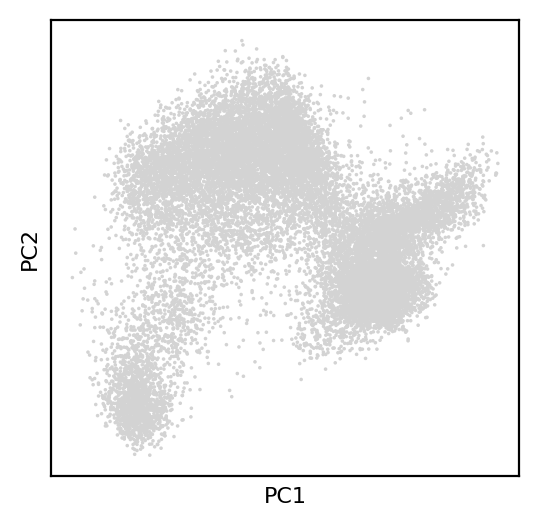

In [9]:
sc.tl.pca(adata_log)
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_log, save="umap_PCA.png" )

In [10]:
sc.pp.neighbors(adata_log, n_neighbors=30)
sc.tl.umap(adata_log)
sc.tl.louvain(adata_log, key_added='louvain_8', resolution=0.80)

In [19]:
#sc.tl.louvain(adata_log, key_added='louvain_8', resolution=0.70)

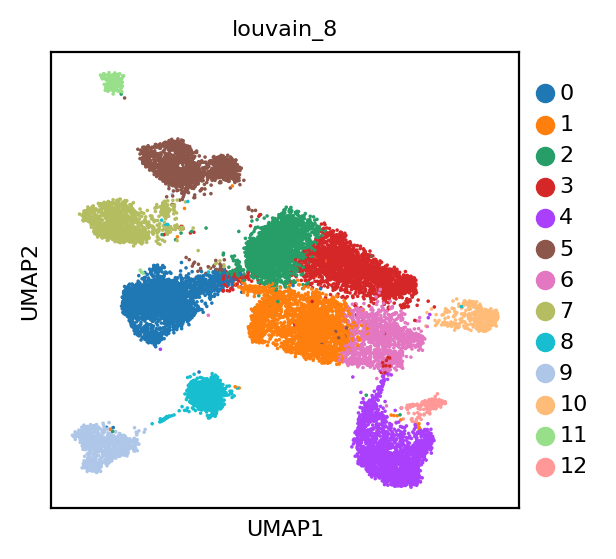

In [12]:
sc.pl.umap(adata_log,color='louvain_8')

In [15]:
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_8']
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('0','PlasmaCell')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('1','Basal_non')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('2','Basal_polyp')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('3','Apical_polyp')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('4','Glandular')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('5','Fibroblast')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('6','Apical_non')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('7','Endothelial')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('8','TCell')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('9','Myeloid')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('10','Ciliated')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('11','MastCell')
adata_log.obs['louvain_subset'] = adata_log.obs['louvain_subset'].replace('12','Unknown')

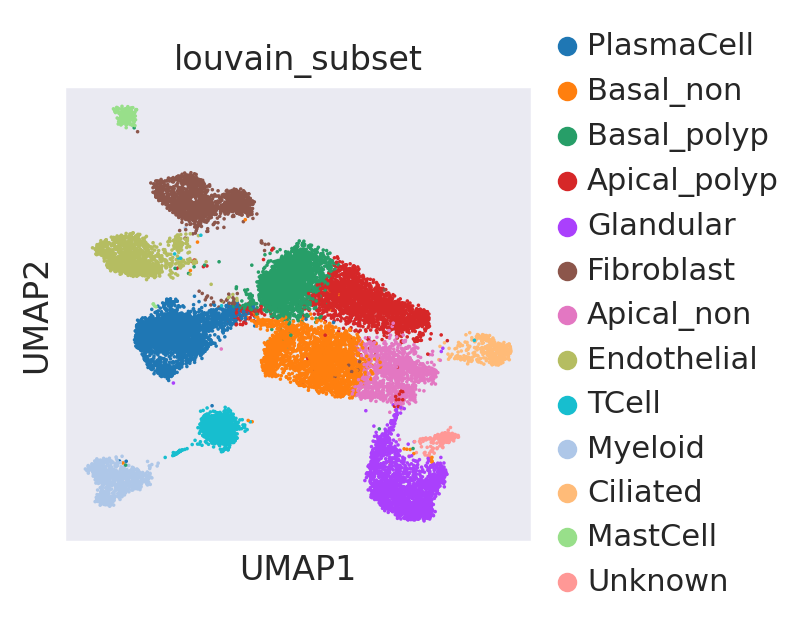

In [77]:
sc.pl.umap(adata_log,color='louvain_subset')

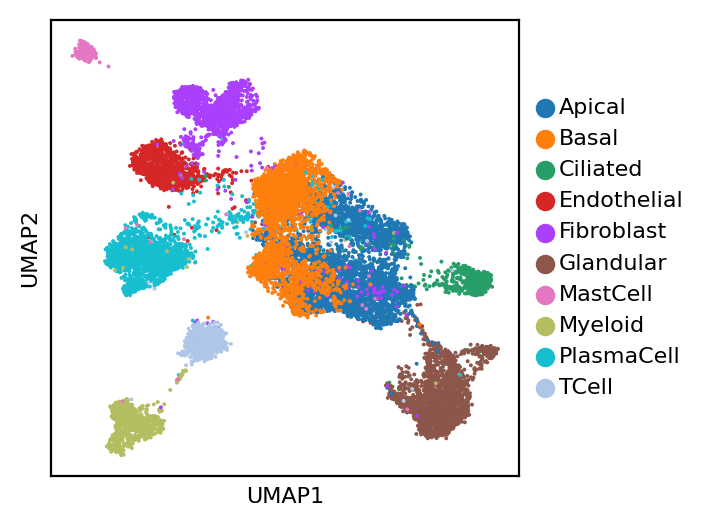

In [20]:
sc.pl.umap(adata_log[adata_log.obs['orig.ident']!='Polyp11TOT'],title='',color='subset',save='_subset')

In [99]:
set(adata_log.obs['subset'])

{'Apical',
 'Basal',
 'Ciliated',
 'Endothelial',
 'Fibroblast',
 'Glandular',
 'MastCell',
 'Myeloid',
 'PlasmaCell',
 'TCell'}

In [95]:
adata_log.obs['subset2'] = adata_log.obs['louvain_8']
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('0','PlasmaCell')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('1','Basal')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('2','Basal')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('3','Apical')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('4','Glandular')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('5','Fibroblast')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('6','Apical')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('7','Endothelial')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('8','TCell')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('9','Myeloid')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('10','Ciliated')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('11','MastCell')
adata_log.obs['subset2'] = adata_log.obs['subset2'].replace('12','Glandular')

In [533]:
sc.pl.umap(adata_log,color='louvain') condition specific annotations using data driven clustering to asses some cell types are very sensitive to conditions and we assess to use 
every cell type has sf purity of -->80% agreement

SyntaxError: invalid syntax (<ipython-input-533-f0a634a5a215>, line 1)

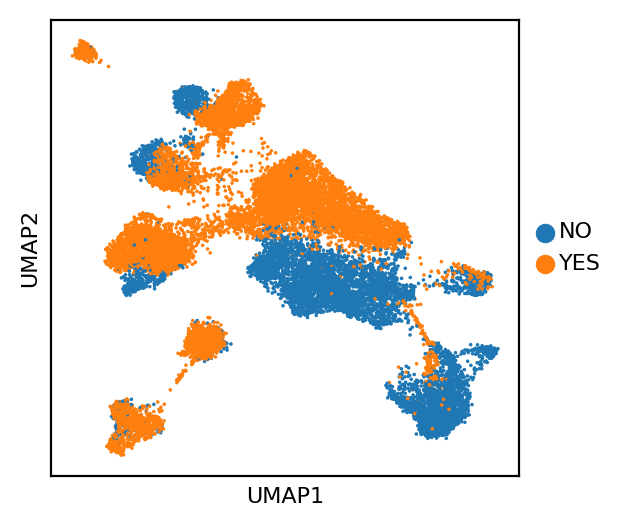

In [19]:
sc.pl.umap(adata_log,color='polyp',title='',save='_polyp')

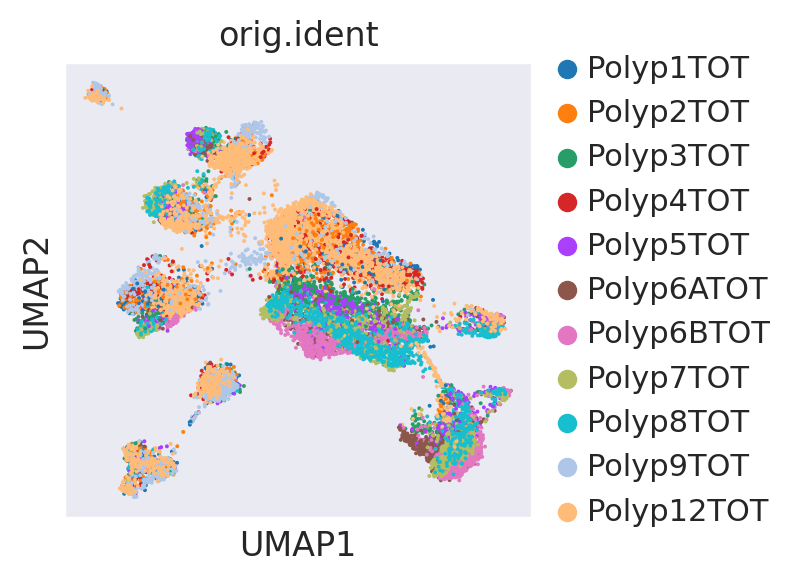

In [127]:
sc.pl.umap(adata_log[adata_log.obs['orig.ident']!='Polyp11TOT'],color='orig.ident')

In [17]:
#adata_log.write(data_file+"adata_log_8.h5ad")

In [43]:
adata_log = sc.read(data_file+"adata_log_8.h5ad")

In [170]:
adata_log_BA= adata_log[adata_log.obs['subset']=='Apical'].copy()
sc.tl.rank_genes_groups(adata_log_BA, groupby='polyp', key_added='rank_polyp')
mg = []
clusters = set(adata_log_BA.obs['polyp'])
markers = pd.DataFrame(columns = clusters)
list_mg = []
for clust in clusters:
    mg=adata_log_BA.uns['rank_polyp']['names'][clust][:20]
    list_mg.extend(mg)
    markers.loc[:,clust] = mg

In [171]:
list_mg

['STATH',
 'EPAS1',
 'ZG16B',
 'ALDH3A1',
 'AQP3',
 'MSMB',
 'LYZ',
 'CLU',
 'GLUL',
 'UGT2A2',
 'SCGB1A1',
 'SCGB3A1',
 'CYP4B1',
 'STEAP4',
 'PSCA',
 'GSTA1',
 'TMEM213',
 'HES1',
 'AQP5',
 'KIF21A',
 'CST1',
 'IGJ',
 'PTHLH',
 'CST4',
 'POSTN',
 'IGFBP3',
 'ALOX15',
 'EGLN3',
 'CST2',
 'MTRNR2L1',
 'CDH26',
 'SERPINB3',
 'TFF3',
 'MIF',
 'SERPINB2',
 'SERPINB4',
 'HS3ST1',
 'RPL13A',
 'RPL41',
 'RPS4Y1']

In [172]:
shared_hv =  np.intersect1d(adata_proc[:,adata_log.var_names[adata_log.var['highly_variable']==True]].var_names,list_mg)

In [173]:
len(shared_hv)

32

In [174]:
shared_hv = list(set(adata_proc[:,adata_log.var_names[adata_log.var['highly_variable']==True]].var_names)-set(shared_hv))

In [175]:
len(shared_hv)

4967

# Deconvolution

## AutoGeneS

In [9]:
adata_proc_norm.obs['louvain_subset'] = adata_log.obs['louvain_subset']
adata_proc_norm.obs['subset'] = adata_log.obs['subset']

Trying to set attribute `.obs` of view, copying.


In [10]:
adata_hv = adata_proc_norm[:,adata_log.var['highly_variable']==True].copy()#[:,shared_hv].copy()

In [11]:
adata_hv = adata_hv[adata_hv.obs['orig.ident']!='Polyp11TOT'].copy()
adata_hv = adata_hv[adata_hv.obs['louvain_subset']!='Unknown']

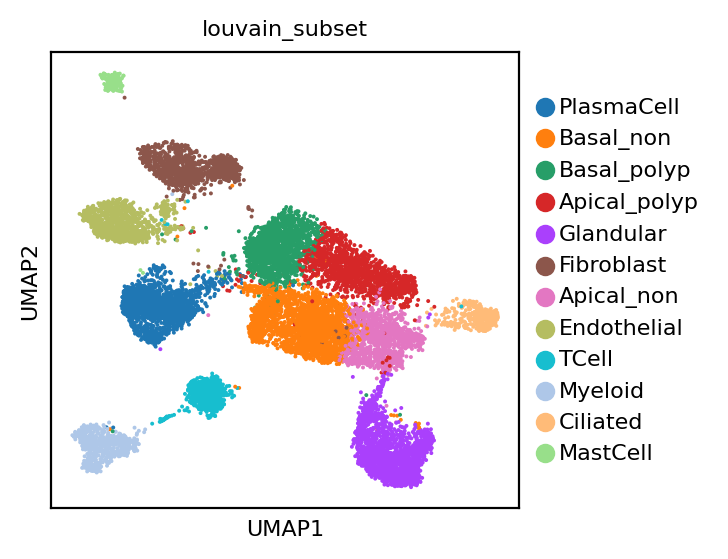

In [21]:
sc.pl.umap(adata_log[adata_hv.obs_names],color='louvain_subset',save='louvain9_subset')

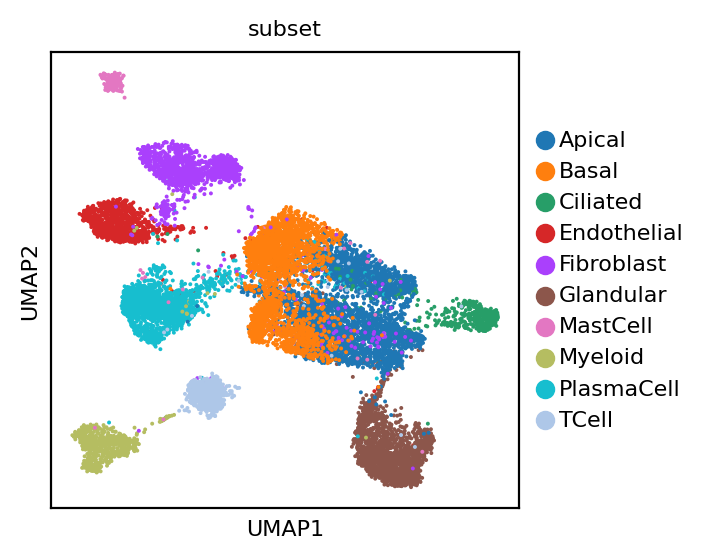

In [22]:
sc.pl.umap(adata_log[adata_hv.obs_names],color='subset',save='_subset')

In [18]:
adata_hv

View of AnnData object with n_obs × n_vars = 14878 × 4999 
    obs: 'nGene', 'nUMI', 'orig.ident', 'diagnosis', 'polyp', 'res.1.2', 'subset', 'n_counts', 'louvain_subset'
    var: 'n_cells'

In [19]:
#adata_hv = sc.read(data_file+"adata_hv_best.h5ad")

In [23]:
import datetime
print(datetime.datetime.now())
time0 = datetime.datetime.now()
import autogenes as ag
ngenes = 400 #400
ngen=5000
centroids = ag.init(adata_hv,use_highly_variable=False,celltype_key='louvain_subset')
ag.optimize(ngen=ngen,seed=0,nfeatures=ngenes,mode='fixed')

print(datetime.datetime.now()-time0) #5.94

2020-06-17 19:29:31.623042
gen	nevals	pareto	correlation  	distance          
0  	100   	7     	11.96 - 55.31	1709.12 - 21189.47
1  	100   	8     	11.02 - 42.25	2040.8 - 21197.06 
2  	100   	9     	10.75 - 41.73	2127.45 - 21197.06
3  	100   	10    	9.28 - 38.64 	2331.41 - 21197.06
4  	100   	14    	9.11 - 38.64 	2432.3 - 21197.07 
5  	100   	17    	8.69 - 38.37 	2432.3 - 21197.07 
6  	100   	14    	8.69 - 38.3  	2432.74 - 21197.07
7  	100   	17    	8.69 - 32.85 	3508.91 - 21197.38
8  	100   	18    	8.56 - 21.6  	3523.4 - 21199.04 
9  	100   	19    	8.45 - 21.6  	3730.65 - 21201.57
10 	100   	18    	8.45 - 21.58 	3730.74 - 21201.57
11 	100   	21    	8.45 - 21.58 	3730.74 - 21201.57
12 	100   	22    	8.45 - 21.58 	3732.85 - 21206.43
13 	100   	20    	8.45 - 21.58 	4469.69 - 21206.43
14 	100   	23    	8.45 - 21.52 	4474.24 - 21209.73
15 	100   	26    	8.45 - 21.49 	4474.81 - 21209.73
16 	100   	16    	8.45 - 21.49 	4475.04 - 21209.73
17 	100   	17    	8.45 - 21.47 	4475.67 - 21325.38
18 	

160	100   	50    	5.58 - 15.58 	5462.42 - 25364.59
161	100   	50    	5.58 - 15.33 	5462.42 - 25364.84
162	100   	43    	5.58 - 15.33 	5462.42 - 25364.84
163	100   	49    	5.58 - 15.33 	5461.99 - 25364.84
164	100   	52    	5.58 - 15.33 	5461.99 - 25364.84
165	100   	52    	5.58 - 15.33 	5461.99 - 25373.09
166	100   	56    	5.58 - 15.33 	5461.93 - 25373.09
167	100   	58    	5.57 - 15.33 	5462.42 - 25373.09
168	100   	60    	5.57 - 15.33 	5462.64 - 25373.09
169	100   	62    	5.57 - 15.32 	5462.64 - 25373.09
170	100   	61    	5.57 - 15.31 	5462.64 - 25373.09
171	100   	59    	5.57 - 15.31 	5462.64 - 25373.09
172	100   	60    	5.57 - 15.31 	5462.64 - 25373.09
173	100   	58    	5.57 - 15.31 	5462.64 - 25374.41
174	100   	60    	5.57 - 15.31 	5462.81 - 25374.41
175	100   	60    	5.57 - 34.24 	5462.81 - 25953.38
176	100   	64    	5.57 - 34.24 	5462.81 - 25953.38
177	100   	66    	5.57 - 34.24 	5462.81 - 25953.38
178	100   	70    	5.57 - 34.24 	5462.81 - 25953.38
179	100   	71    	5.57 - 34.24 

321	100   	64    	4.61 - 34.73 	5531.19 - 26275.64
322	100   	58    	4.61 - 34.73 	5531.19 - 26275.64
323	100   	56    	4.61 - 34.73 	5531.19 - 26275.65
324	100   	57    	4.61 - 34.73 	5531.19 - 26275.65
325	100   	55    	4.55 - 34.73 	5531.42 - 26275.65
326	100   	60    	4.55 - 34.73 	5531.42 - 26277.14
327	100   	64    	4.55 - 34.73 	5531.42 - 26277.14
328	100   	67    	4.55 - 34.73 	5551.93 - 26277.14
329	100   	66    	4.55 - 34.73 	5551.91 - 26277.14
330	100   	68    	4.54 - 34.73 	7454.73 - 26277.14
331	100   	73    	4.54 - 34.73 	7454.73 - 26277.14
332	100   	77    	4.54 - 34.73 	7454.73 - 26277.14
333	100   	72    	4.52 - 34.73 	7448.32 - 26277.14
334	100   	72    	4.52 - 34.73 	7417.31 - 26277.14
335	100   	74    	4.51 - 34.73 	7417.31 - 26277.14
336	100   	80    	4.51 - 34.73 	7417.31 - 26277.14
337	100   	79    	4.51 - 34.73 	7417.31 - 26277.14
338	100   	83    	4.51 - 34.73 	7417.31 - 26277.14
339	100   	71    	4.51 - 34.72 	7417.31 - 26278.07
340	100   	63    	4.51 - 34.72 

483	100   	97    	3.89 - 12.12 	7175.46 - 26535.81
484	100   	95    	3.89 - 12.12 	7175.78 - 26535.81
485	100   	93    	3.89 - 15.41 	7175.78 - 26692.13
486	100   	93    	3.89 - 15.41 	7175.78 - 26692.13
487	100   	97    	3.89 - 15.41 	7175.78 - 26692.13
488	100   	95    	3.89 - 15.41 	7175.78 - 26692.13
489	100   	81    	3.89 - 15.41 	7175.78 - 26692.13
490	100   	84    	3.89 - 15.41 	7175.78 - 26692.13
491	100   	91    	3.89 - 15.41 	7175.78 - 26692.13
492	100   	98    	3.89 - 15.46 	7175.78 - 26727.64
493	100   	103   	3.89 - 15.46 	7175.78 - 26727.64
494	100   	97    	3.89 - 15.46 	7175.78 - 26727.64
495	100   	90    	3.89 - 15.46 	7175.78 - 26727.64
496	100   	91    	3.89 - 15.46 	7175.78 - 26727.64
497	100   	86    	3.85 - 15.46 	7176.34 - 26727.64
498	100   	75    	3.85 - 15.46 	7176.34 - 26727.64
499	100   	76    	3.85 - 15.46 	7176.34 - 26727.64
500	100   	71    	3.81 - 17.51 	7215.4 - 26727.64 
501	100   	74    	3.81 - 17.51 	7272.75 - 26727.64
502	100   	79    	3.81 - 15.46 

644	100   	82    	3.15 - 15.68 	7121.89 - 28279.36
645	100   	80    	3.15 - 15.68 	7121.89 - 28279.36
646	100   	83    	3.13 - 15.68 	7121.89 - 28279.36
647	100   	83    	3.13 - 15.68 	7121.89 - 28279.5 
648	100   	89    	3.13 - 15.68 	7147.54 - 28279.5 
649	100   	88    	3.13 - 15.68 	7147.54 - 28279.5 
650	100   	84    	3.13 - 15.68 	7147.54 - 28279.5 
651	100   	87    	3.13 - 15.68 	7147.54 - 28279.5 
652	100   	87    	3.13 - 15.68 	7147.54 - 28279.5 
653	100   	78    	3.07 - 15.68 	7150.34 - 28279.5 
654	100   	76    	3.07 - 15.68 	7150.34 - 28279.5 
655	100   	77    	3.07 - 15.68 	7150.34 - 28279.5 
656	100   	82    	3.07 - 15.68 	7150.34 - 28279.5 
657	100   	82    	3.07 - 15.68 	7150.34 - 28279.5 
658	100   	85    	3.07 - 15.67 	7150.34 - 28366.33
659	100   	78    	3.07 - 15.67 	7150.34 - 28366.33
660	100   	80    	3.07 - 15.64 	7150.34 - 28369.35
661	100   	75    	3.07 - 15.65 	7150.34 - 28369.35
662	100   	73    	3.07 - 15.65 	7150.34 - 28369.35
663	100   	73    	3.07 - 15.65 

806	100   	144   	2.94 - 15.09 	7306.51 - 29241.63
807	100   	139   	2.94 - 15.09 	7306.51 - 29241.63
808	100   	142   	2.94 - 15.09 	7306.51 - 29241.63
809	100   	146   	2.94 - 15.09 	7306.51 - 29241.63
810	100   	148   	2.94 - 15.09 	7306.51 - 29241.63
811	100   	151   	2.94 - 15.09 	7306.51 - 29241.63
812	100   	164   	2.94 - 15.09 	7306.51 - 29241.63
813	100   	170   	2.94 - 15.09 	7302.45 - 29241.63
814	100   	169   	2.94 - 15.09 	7302.45 - 29241.63
815	100   	167   	2.94 - 15.09 	7302.45 - 29241.63
816	100   	171   	2.94 - 15.09 	7302.45 - 29241.63
817	100   	168   	2.94 - 15.09 	7302.45 - 29241.63
818	100   	169   	2.94 - 15.09 	7302.45 - 29241.63
819	100   	167   	2.94 - 15.09 	7302.45 - 29241.63
820	100   	170   	2.94 - 15.09 	7302.45 - 29241.63
821	100   	172   	2.94 - 15.09 	7302.45 - 29241.63
822	100   	173   	2.94 - 15.09 	7302.45 - 29241.63
823	100   	179   	2.94 - 15.09 	7300.94 - 29241.63
824	100   	180   	2.94 - 15.09 	7300.94 - 29241.63
825	100   	190   	2.9 - 15.09  

967	100   	202   	2.72 - 16.35 	7008.9 - 29536.05 
968	100   	203   	2.72 - 16.35 	7008.9 - 29536.05 
969	100   	200   	2.72 - 16.35 	7008.9 - 29536.05 
970	100   	206   	2.72 - 16.35 	7008.9 - 29536.05 
971	100   	204   	2.72 - 16.35 	7008.9 - 29536.05 
972	100   	209   	2.72 - 16.35 	7008.9 - 29536.05 
973	100   	213   	2.72 - 16.35 	7008.9 - 29536.05 
974	100   	221   	2.72 - 16.35 	7008.77 - 29536.05
975	100   	222   	2.72 - 16.35 	7008.77 - 29536.05
976	100   	212   	2.72 - 16.35 	7008.77 - 29536.05
977	100   	206   	2.72 - 16.35 	7008.77 - 29536.05
978	100   	200   	2.72 - 16.35 	7008.77 - 29536.05
979	100   	200   	2.72 - 16.35 	7008.77 - 29536.05
980	100   	208   	2.72 - 16.35 	7008.77 - 29536.05
981	100   	214   	2.72 - 16.35 	7008.77 - 29536.05
982	100   	203   	2.72 - 16.35 	7008.77 - 29536.05
983	100   	207   	2.72 - 16.35 	7008.77 - 29536.05
984	100   	207   	2.72 - 16.35 	7008.77 - 29536.05
985	100   	207   	2.71 - 16.35 	7008.94 - 29536.82
986	100   	202   	2.71 - 16.35 

1126	100   	190   	2.67 - 15.98 	6986.03 - 29722.67
1127	100   	193   	2.67 - 15.98 	6986.03 - 29722.67
1128	100   	192   	2.66 - 15.98 	6986.06 - 29722.67
1129	100   	199   	2.66 - 15.98 	6986.06 - 29722.67
1130	100   	202   	2.66 - 15.98 	6986.06 - 29722.67
1131	100   	198   	2.66 - 15.98 	6986.06 - 29722.67
1132	100   	197   	2.66 - 15.98 	6986.06 - 29722.67
1133	100   	201   	2.66 - 15.98 	6986.06 - 29722.67
1134	100   	205   	2.66 - 15.98 	6986.06 - 29722.67
1135	100   	207   	2.66 - 15.98 	6986.06 - 29722.67
1136	100   	210   	2.66 - 15.98 	6986.06 - 29722.67
1137	100   	208   	2.66 - 15.98 	6986.06 - 29722.67
1138	100   	210   	2.66 - 15.98 	6986.06 - 29722.67
1139	100   	206   	2.66 - 15.98 	6986.06 - 29722.67
1140	100   	209   	2.66 - 15.98 	6986.06 - 29722.67
1141	100   	205   	2.66 - 15.98 	6986.06 - 29722.67
1142	100   	210   	2.66 - 15.98 	6986.06 - 29722.67
1143	100   	208   	2.66 - 15.98 	6986.06 - 29722.67
1144	100   	216   	2.66 - 15.98 	6985.88 - 29722.67
1145	100   	

1284	100   	276   	2.64 - 15.62 	7114.66 - 30144.0 
1285	100   	277   	2.64 - 15.62 	7114.66 - 30144.0 
1286	100   	280   	2.64 - 15.62 	7114.66 - 30144.0 
1287	100   	281   	2.64 - 15.62 	7114.66 - 30144.0 
1288	100   	276   	2.64 - 15.62 	7114.66 - 30144.0 
1289	100   	277   	2.63 - 15.62 	7113.27 - 30144.0 
1290	100   	282   	2.63 - 15.62 	7113.27 - 30144.0 
1291	100   	286   	2.63 - 15.62 	7112.71 - 30144.0 
1292	100   	289   	2.63 - 15.62 	7112.71 - 30144.0 
1293	100   	288   	2.63 - 15.62 	7112.71 - 30144.0 
1294	100   	293   	2.63 - 15.62 	7112.71 - 30144.0 
1295	100   	294   	2.63 - 15.62 	7112.71 - 30144.0 
1296	100   	289   	2.63 - 15.62 	7112.71 - 30144.0 
1297	100   	288   	2.63 - 15.62 	7112.66 - 30144.0 
1298	100   	287   	2.63 - 15.62 	7112.66 - 30144.0 
1299	100   	291   	2.63 - 15.62 	7112.66 - 30144.0 
1300	100   	288   	2.63 - 15.62 	7112.66 - 30144.0 
1301	100   	292   	2.63 - 15.62 	7112.66 - 30144.0 
1302	100   	291   	2.63 - 15.62 	7112.66 - 30144.0 
1303	100   	

1443	100   	271   	2.59 - 15.69 	6829.31 - 30168.65
1444	100   	268   	2.59 - 15.69 	6829.31 - 30168.65
1445	100   	269   	2.59 - 15.68 	6829.31 - 30168.86
1446	100   	269   	2.59 - 15.68 	6829.31 - 30168.86
1447	100   	268   	2.59 - 15.68 	6829.31 - 30168.86
1448	100   	271   	2.59 - 15.68 	6829.31 - 30168.86
1449	100   	268   	2.59 - 15.68 	6829.31 - 30168.86
1450	100   	267   	2.59 - 15.68 	6829.31 - 30168.86
1451	100   	266   	2.59 - 15.68 	6829.31 - 30168.86
1452	100   	262   	2.59 - 15.68 	6829.31 - 30168.86
1453	100   	272   	2.59 - 15.68 	6829.31 - 30168.86
1454	100   	271   	2.59 - 15.68 	6829.31 - 30168.86
1455	100   	275   	2.59 - 15.68 	6829.31 - 30168.86
1456	100   	274   	2.59 - 15.68 	6829.31 - 30168.86
1457	100   	276   	2.59 - 15.68 	6829.31 - 30168.86
1458	100   	280   	2.59 - 15.68 	6829.31 - 30168.86
1459	100   	280   	2.59 - 15.68 	6829.31 - 30168.86
1460	100   	280   	2.59 - 15.68 	6829.31 - 30168.86
1461	100   	287   	2.59 - 15.68 	6829.31 - 30168.86
1462	100   	

1602	100   	319   	2.54 - 17.12 	7153.45 - 30348.46
1603	100   	316   	2.54 - 17.12 	7153.45 - 30348.46
1604	100   	313   	2.54 - 17.12 	7153.45 - 30348.46
1605	100   	306   	2.54 - 17.12 	7153.45 - 30348.46
1606	100   	310   	2.54 - 17.12 	7153.45 - 30348.46
1607	100   	293   	2.54 - 17.11 	7153.45 - 30349.35
1608	100   	287   	2.54 - 17.11 	7156.46 - 30349.35
1609	100   	280   	2.54 - 17.11 	7156.46 - 30349.35
1610	100   	276   	2.54 - 17.11 	7156.46 - 30349.35
1611	100   	279   	2.54 - 17.11 	7156.46 - 30349.35
1612	100   	278   	2.54 - 17.11 	7156.46 - 30349.35
1613	100   	280   	2.54 - 17.11 	7156.47 - 30349.35
1614	100   	277   	2.54 - 17.11 	7156.53 - 30349.35
1615	100   	278   	2.54 - 17.11 	7156.44 - 30349.35
1616	100   	279   	2.54 - 17.11 	7156.44 - 30349.35
1617	100   	279   	2.54 - 17.1  	7156.44 - 30351.33
1618	100   	277   	2.54 - 17.1  	7156.44 - 30351.33
1619	100   	269   	2.54 - 17.1  	7156.44 - 30351.33
1620	100   	273   	2.54 - 17.1  	7156.44 - 30352.11
1621	100   	

1760	100   	300   	2.52 - 17.07 	7155.14 - 30357.14
1761	100   	302   	2.52 - 17.06 	7155.14 - 30357.27
1762	100   	305   	2.52 - 17.06 	7155.14 - 30357.27
1763	100   	305   	2.52 - 17.06 	7155.14 - 30357.27
1764	100   	307   	2.52 - 17.06 	7155.14 - 30357.27
1765	100   	308   	2.52 - 17.06 	7155.14 - 30357.27
1766	100   	307   	2.52 - 17.06 	7155.14 - 30357.27
1767	100   	309   	2.52 - 17.06 	7155.5 - 30357.27 
1768	100   	308   	2.52 - 17.06 	7155.5 - 30357.27 
1769	100   	313   	2.52 - 17.06 	7155.5 - 30357.27 
1770	100   	314   	2.52 - 17.06 	7155.5 - 30357.27 
1771	100   	315   	2.52 - 17.06 	7155.5 - 30357.27 
1772	100   	319   	2.52 - 17.06 	7155.5 - 30357.27 
1773	100   	324   	2.52 - 17.06 	7155.5 - 30357.27 
1774	100   	317   	2.52 - 17.06 	7155.5 - 30357.27 
1775	100   	319   	2.52 - 17.06 	7155.5 - 30357.27 
1776	100   	317   	2.52 - 17.06 	7155.5 - 30357.27 
1777	100   	314   	2.52 - 17.06 	7155.5 - 30357.27 
1778	100   	313   	2.52 - 17.06 	7155.5 - 30357.27 
1779	100   	

1918	100   	360   	2.45 - 23.99 	7146.88 - 30497.73
1919	100   	366   	2.45 - 23.98 	7146.88 - 30498.1 
1920	100   	364   	2.45 - 23.98 	7146.88 - 30498.1 
1921	100   	366   	2.45 - 23.98 	7146.88 - 30498.1 
1922	100   	369   	2.45 - 23.98 	7146.88 - 30498.1 
1923	100   	372   	2.45 - 23.98 	7146.88 - 30498.1 
1924	100   	372   	2.45 - 23.98 	7146.88 - 30498.1 
1925	100   	370   	2.45 - 23.98 	7146.88 - 30498.1 
1926	100   	372   	2.45 - 23.98 	7146.88 - 30498.1 
1927	100   	371   	2.45 - 23.98 	7146.88 - 30498.1 
1928	100   	374   	2.45 - 23.98 	7146.88 - 30498.1 
1929	100   	375   	2.45 - 23.98 	7146.88 - 30498.1 
1930	100   	376   	2.45 - 23.98 	7146.88 - 30498.1 
1931	100   	376   	2.45 - 23.98 	7146.88 - 30498.1 
1932	100   	377   	2.45 - 23.98 	7146.88 - 30498.1 
1933	100   	379   	2.45 - 23.98 	7146.88 - 30498.1 
1934	100   	382   	2.45 - 23.98 	7146.88 - 30498.1 
1935	100   	382   	2.45 - 23.98 	7146.88 - 30498.1 
1936	100   	384   	2.45 - 23.98 	7146.88 - 30498.1 
1937	100   	

2077	100   	401   	2.43 - 23.93 	7146.9 - 30508.37 
2078	100   	403   	2.43 - 23.93 	7146.9 - 30508.37 
2079	100   	407   	2.43 - 23.93 	7146.9 - 30508.37 
2080	100   	408   	2.43 - 23.93 	7146.9 - 30508.37 
2081	100   	413   	2.43 - 23.93 	7146.9 - 30508.37 
2082	100   	416   	2.43 - 23.93 	7146.9 - 30508.37 
2083	100   	416   	2.43 - 23.93 	7146.9 - 30508.37 
2084	100   	417   	2.43 - 23.93 	7146.9 - 30508.37 
2085	100   	415   	2.43 - 23.93 	7146.9 - 30508.37 
2086	100   	413   	2.43 - 23.93 	7146.9 - 30508.37 
2087	100   	408   	2.43 - 23.93 	7146.9 - 30508.37 
2088	100   	413   	2.43 - 23.93 	7146.9 - 30508.37 
2089	100   	418   	2.43 - 23.93 	7146.9 - 30508.37 
2090	100   	421   	2.43 - 23.93 	7146.9 - 30508.37 
2091	100   	418   	2.43 - 23.93 	7146.9 - 30508.37 
2092	100   	418   	2.43 - 23.93 	7145.1 - 30508.37 
2093	100   	411   	2.43 - 23.93 	7145.1 - 30508.37 
2094	100   	413   	2.43 - 23.93 	7145.1 - 30508.37 
2095	100   	414   	2.43 - 23.93 	7145.1 - 30508.37 
2096	100   	

2235	100   	363   	2.42 - 16.26 	7137.69 - 30599.98
2236	100   	365   	2.42 - 16.26 	7137.69 - 30599.98
2237	100   	369   	2.42 - 16.26 	7137.69 - 30599.98
2238	100   	373   	2.42 - 16.26 	7137.69 - 30599.98
2239	100   	373   	2.42 - 16.26 	7137.69 - 30600.29
2240	100   	374   	2.42 - 16.26 	7137.69 - 30600.31
2241	100   	372   	2.42 - 16.26 	7137.69 - 30600.31
2242	100   	367   	2.42 - 16.26 	7137.69 - 30600.31
2243	100   	372   	2.42 - 16.26 	7137.69 - 30600.31
2244	100   	367   	2.42 - 16.26 	7137.69 - 30600.81
2245	100   	369   	2.42 - 16.26 	7137.69 - 30600.81
2246	100   	372   	2.42 - 16.26 	7137.69 - 30600.81
2247	100   	371   	2.42 - 16.26 	7137.69 - 30600.81
2248	100   	378   	2.42 - 16.26 	7137.69 - 30600.81
2249	100   	379   	2.42 - 16.26 	7137.69 - 30600.81
2250	100   	381   	2.42 - 16.26 	7137.69 - 30600.81
2251	100   	381   	2.42 - 16.26 	7137.69 - 30600.81
2252	100   	384   	2.42 - 16.26 	7137.78 - 30600.81
2253	100   	385   	2.42 - 16.26 	7137.78 - 30600.81
2254	100   	

2394	100   	396   	2.41 - 18.01 	7135.4 - 30664.24 
2395	100   	395   	2.41 - 18.01 	7135.4 - 30664.24 
2396	100   	384   	2.41 - 18.01 	7135.4 - 30664.24 
2397	100   	383   	2.41 - 18.01 	7135.4 - 30664.24 
2398	100   	387   	2.41 - 18.01 	7135.4 - 30664.24 
2399	100   	390   	2.41 - 18.01 	7135.4 - 30664.24 
2400	100   	393   	2.41 - 18.01 	7135.4 - 30664.24 
2401	100   	391   	2.41 - 18.01 	7135.57 - 30664.24
2402	100   	392   	2.41 - 18.01 	7135.57 - 30664.24
2403	100   	388   	2.41 - 18.01 	7135.57 - 30664.24
2404	100   	385   	2.41 - 18.01 	7135.57 - 30664.24
2405	100   	386   	2.41 - 18.01 	7135.57 - 30664.24
2406	100   	381   	2.41 - 18.01 	7135.57 - 30664.24
2407	100   	377   	2.41 - 18.01 	7135.57 - 30664.24
2408	100   	382   	2.41 - 18.01 	7135.57 - 30664.24
2409	100   	384   	2.41 - 18.01 	7135.57 - 30664.24
2410	100   	383   	2.41 - 18.01 	7135.57 - 30664.34
2411	100   	388   	2.41 - 18.01 	7135.57 - 30664.34
2412	100   	390   	2.41 - 18.01 	7135.57 - 30664.34
2413	100   	

2552	100   	423   	2.41 - 20.83 	7473.28 - 30897.55
2553	100   	425   	2.41 - 20.83 	7473.28 - 30897.55
2554	100   	426   	2.41 - 20.83 	7473.28 - 30897.55
2555	100   	423   	2.41 - 20.83 	7473.28 - 30897.55
2556	100   	420   	2.41 - 20.82 	7473.28 - 30897.66
2557	100   	421   	2.41 - 20.82 	7473.28 - 30897.66
2558	100   	422   	2.41 - 20.82 	7473.28 - 30897.66
2559	100   	421   	2.41 - 20.83 	7473.28 - 30897.95
2560	100   	422   	2.41 - 20.83 	7473.28 - 30897.95
2561	100   	422   	2.41 - 20.83 	7473.28 - 30897.95
2562	100   	423   	2.41 - 20.83 	7473.28 - 30897.95
2563	100   	423   	2.41 - 20.83 	7473.28 - 30897.95
2564	100   	421   	2.41 - 20.83 	7473.28 - 30897.95
2565	100   	425   	2.41 - 20.83 	7473.28 - 30897.95
2566	100   	420   	2.41 - 20.83 	7473.28 - 30897.95
2567	100   	414   	2.41 - 20.83 	7473.28 - 30897.95
2568	100   	412   	2.41 - 20.83 	7473.28 - 30897.95
2569	100   	410   	2.41 - 20.83 	7473.28 - 30897.95
2570	100   	410   	2.41 - 20.83 	7473.28 - 30897.95
2571	100   	

2710	100   	432   	2.4 - 20.73  	7472.57 - 30914.45
2711	100   	433   	2.4 - 20.73  	7472.57 - 30914.45
2712	100   	434   	2.4 - 20.73  	7472.57 - 30914.45
2713	100   	434   	2.4 - 20.73  	7472.57 - 30914.45
2714	100   	430   	2.4 - 20.73  	7472.57 - 30914.45
2715	100   	433   	2.4 - 20.73  	7472.57 - 30914.45
2716	100   	435   	2.4 - 20.73  	7472.57 - 30914.45
2717	100   	436   	2.4 - 20.73  	7472.57 - 30914.45
2718	100   	439   	2.4 - 20.73  	7472.57 - 30914.45
2719	100   	435   	2.4 - 20.73  	7472.57 - 30914.45
2720	100   	434   	2.4 - 20.73  	7472.57 - 30914.45
2721	100   	439   	2.4 - 20.73  	7472.54 - 30914.45
2722	100   	445   	2.4 - 20.73  	7472.54 - 30914.45
2723	100   	448   	2.4 - 20.73  	7472.54 - 30914.45
2724	100   	444   	2.4 - 20.73  	7472.54 - 30914.45
2725	100   	435   	2.4 - 20.71  	7472.54 - 30914.78
2726	100   	433   	2.4 - 20.71  	7472.54 - 30914.78
2727	100   	427   	2.4 - 20.71  	7472.54 - 30914.78
2728	100   	432   	2.4 - 20.71  	7472.54 - 30914.78
2729	100   	

2869	100   	421   	2.37 - 20.65 	7412.45 - 30933.64
2870	100   	416   	2.37 - 20.65 	7412.45 - 30933.64
2871	100   	418   	2.37 - 20.65 	7412.45 - 30933.64
2872	100   	423   	2.37 - 20.65 	7412.68 - 30933.64
2873	100   	421   	2.37 - 20.65 	7412.68 - 30933.64
2874	100   	418   	2.37 - 20.65 	7412.68 - 30933.64
2875	100   	417   	2.37 - 20.65 	7412.68 - 30933.64
2876	100   	417   	2.37 - 20.65 	7412.68 - 30933.64
2877	100   	421   	2.37 - 20.65 	7412.68 - 30933.64
2878	100   	425   	2.37 - 20.65 	7412.68 - 30933.64
2879	100   	424   	2.37 - 20.65 	7412.68 - 30933.64
2880	100   	426   	2.37 - 20.65 	7412.68 - 30933.64
2881	100   	425   	2.37 - 20.65 	7412.68 - 30933.64
2882	100   	426   	2.37 - 20.41 	7412.68 - 30986.87
2883	100   	428   	2.37 - 20.41 	7412.68 - 30986.87
2884	100   	427   	2.37 - 20.41 	7412.68 - 30986.87
2885	100   	420   	2.37 - 20.41 	7413.88 - 30986.87
2886	100   	423   	2.37 - 20.41 	7413.88 - 30986.9 
2887	100   	428   	2.37 - 20.41 	7413.88 - 30986.9 
2888	100   	

3027	100   	436   	2.34 - 20.39 	7427.92 - 30989.7 
3028	100   	435   	2.34 - 20.39 	7427.92 - 30989.7 
3029	100   	440   	2.34 - 20.39 	7427.92 - 30989.93
3030	100   	443   	2.34 - 20.39 	7427.92 - 30989.93
3031	100   	436   	2.34 - 20.39 	7427.92 - 30989.93
3032	100   	439   	2.34 - 20.39 	7427.92 - 30989.93
3033	100   	440   	2.34 - 20.39 	7427.92 - 30989.93
3034	100   	439   	2.34 - 20.39 	7427.92 - 30989.93
3035	100   	440   	2.34 - 20.39 	7428.21 - 30989.93
3036	100   	437   	2.34 - 20.39 	7428.21 - 30989.93
3037	100   	442   	2.34 - 20.39 	7428.21 - 30989.93
3038	100   	449   	2.34 - 20.39 	7428.21 - 30989.93
3039	100   	446   	2.34 - 20.39 	7428.21 - 30989.93
3040	100   	444   	2.34 - 20.39 	7428.21 - 30989.93
3041	100   	441   	2.34 - 20.39 	7428.21 - 30989.93
3042	100   	446   	2.34 - 20.39 	7428.21 - 30989.93
3043	100   	447   	2.34 - 20.39 	7428.21 - 30989.93
3044	100   	447   	2.34 - 20.39 	7428.21 - 30989.93
3045	100   	449   	2.34 - 20.39 	7428.21 - 30989.93
3046	100   	

3185	100   	438   	2.33 - 17.91 	7428.87 - 31060.22
3186	100   	439   	2.33 - 17.91 	7428.87 - 31060.22
3187	100   	445   	2.33 - 17.91 	7428.87 - 31060.22
3188	100   	448   	2.33 - 17.91 	7428.87 - 31060.22
3189	100   	446   	2.33 - 17.91 	7428.87 - 31060.22
3190	100   	451   	2.33 - 17.91 	7428.87 - 31060.22
3191	100   	452   	2.33 - 17.91 	7428.87 - 31060.22
3192	100   	454   	2.33 - 17.91 	7428.87 - 31060.22
3193	100   	451   	2.33 - 17.91 	7428.87 - 31060.22
3194	100   	454   	2.33 - 17.91 	7428.87 - 31060.22
3195	100   	451   	2.33 - 17.91 	7428.87 - 31060.22
3196	100   	446   	2.33 - 17.91 	7428.87 - 31060.25
3197	100   	448   	2.33 - 17.91 	7428.87 - 31060.25
3198	100   	453   	2.33 - 17.91 	7427.28 - 31060.25
3199	100   	457   	2.33 - 17.91 	7427.28 - 31060.25
3200	100   	448   	2.33 - 17.91 	7427.28 - 31060.25
3201	100   	448   	2.33 - 17.91 	7427.28 - 31060.52
3202	100   	447   	2.33 - 17.91 	7427.28 - 31060.52
3203	100   	451   	2.33 - 17.91 	7427.28 - 31060.52
3204	100   	

3343	100   	429   	2.32 - 17.75 	7426.01 - 31147.51
3344	100   	430   	2.32 - 17.75 	7426.01 - 31147.51
3345	100   	431   	2.32 - 17.75 	7426.01 - 31147.51
3346	100   	429   	2.32 - 17.75 	7426.01 - 31147.51
3347	100   	428   	2.32 - 17.75 	7426.01 - 31147.51
3348	100   	429   	2.32 - 17.75 	7426.01 - 31147.51
3349	100   	431   	2.32 - 17.75 	7426.01 - 31147.51
3350	100   	427   	2.32 - 17.75 	7426.01 - 31147.51
3351	100   	420   	2.32 - 17.75 	7426.01 - 31147.51
3352	100   	420   	2.32 - 17.75 	7426.01 - 31147.51
3353	100   	422   	2.32 - 17.74 	7426.01 - 31150.16
3354	100   	415   	2.32 - 17.74 	7426.01 - 31150.16
3355	100   	418   	2.32 - 17.74 	7426.01 - 31150.16
3356	100   	416   	2.32 - 17.74 	7426.01 - 31150.16
3357	100   	418   	2.32 - 17.74 	7426.01 - 31150.16
3358	100   	422   	2.32 - 17.74 	7342.94 - 31150.16
3359	100   	424   	2.32 - 17.74 	7342.94 - 31150.16
3360	100   	426   	2.32 - 17.74 	7342.94 - 31150.16
3361	100   	413   	2.32 - 17.74 	7342.94 - 31150.16
3362	100   	

3502	100   	461   	2.31 - 17.73 	7341.4 - 31151.95 
3503	100   	461   	2.31 - 17.73 	7341.4 - 31151.95 
3504	100   	449   	2.31 - 17.73 	7341.4 - 31151.95 
3505	100   	441   	2.31 - 17.73 	7341.4 - 31151.95 
3506	100   	431   	2.31 - 17.72 	7341.4 - 31152.11 
3507	100   	429   	2.31 - 17.72 	7341.4 - 31152.11 
3508	100   	424   	2.31 - 17.72 	7341.4 - 31152.11 
3509	100   	428   	2.31 - 17.72 	7341.26 - 31152.11
3510	100   	428   	2.31 - 17.72 	7341.26 - 31152.11
3511	100   	428   	2.31 - 17.72 	7341.26 - 31152.11
3512	100   	433   	2.31 - 17.72 	7341.26 - 31152.11
3513	100   	438   	2.31 - 17.72 	7341.26 - 31152.11
3514	100   	431   	2.31 - 17.72 	7341.26 - 31152.11
3515	100   	429   	2.31 - 17.72 	7341.26 - 31152.11
3516	100   	427   	2.31 - 17.72 	7341.26 - 31152.11
3517	100   	429   	2.31 - 17.72 	7341.26 - 31152.11
3518	100   	427   	2.31 - 17.72 	7341.26 - 31152.11
3519	100   	427   	2.31 - 17.72 	7341.26 - 31152.11
3520	100   	426   	2.31 - 17.72 	7341.26 - 31152.11
3521	100   	

3660	100   	471   	2.3 - 18.13  	7357.09 - 31207.32
3661	100   	474   	2.3 - 18.13  	7357.09 - 31207.32
3662	100   	470   	2.3 - 18.13  	7357.09 - 31207.32
3663	100   	468   	2.3 - 18.13  	7357.09 - 31207.32
3664	100   	473   	2.3 - 18.13  	7357.09 - 31207.32
3665	100   	475   	2.3 - 18.13  	7357.09 - 31207.32
3666	100   	478   	2.3 - 18.13  	7357.09 - 31207.32
3667	100   	480   	2.3 - 18.13  	7357.09 - 31207.32
3668	100   	482   	2.3 - 18.13  	7357.09 - 31207.68
3669	100   	476   	2.3 - 18.13  	7357.09 - 31207.68
3670	100   	480   	2.3 - 18.13  	7357.09 - 31207.68
3671	100   	483   	2.3 - 18.13  	7357.09 - 31207.68
3672	100   	475   	2.3 - 18.13  	7357.09 - 31207.68
3673	100   	477   	2.3 - 18.13  	7357.09 - 31207.68
3674	100   	479   	2.3 - 18.13  	7357.09 - 31207.68
3675	100   	479   	2.3 - 18.13  	7357.09 - 31207.68
3676	100   	472   	2.3 - 18.12  	7357.09 - 31208.37
3677	100   	471   	2.3 - 18.12  	7357.09 - 31208.37
3678	100   	474   	2.3 - 18.12  	7357.09 - 31208.37
3679	100   	

3818	100   	470   	2.29 - 18.11 	7371.55 - 31209.98
3819	100   	465   	2.29 - 18.11 	7371.55 - 31209.98
3820	100   	466   	2.29 - 18.11 	7371.55 - 31209.98
3821	100   	470   	2.29 - 18.11 	7371.55 - 31209.98
3822	100   	473   	2.29 - 18.11 	7371.55 - 31209.98
3823	100   	459   	2.29 - 18.11 	7371.55 - 31209.98
3824	100   	461   	2.29 - 18.11 	7371.55 - 31209.98
3825	100   	464   	2.29 - 18.11 	7371.55 - 31209.98
3826	100   	469   	2.29 - 18.11 	7371.55 - 31209.98
3827	100   	469   	2.29 - 18.11 	7371.55 - 31209.98
3828	100   	469   	2.29 - 18.11 	7371.55 - 31209.98
3829	100   	471   	2.29 - 18.11 	7371.55 - 31209.98
3830	100   	473   	2.29 - 18.11 	7371.55 - 31209.98
3831	100   	472   	2.29 - 18.11 	7371.55 - 31209.98
3832	100   	474   	2.29 - 18.11 	7371.55 - 31209.98
3833	100   	479   	2.29 - 18.11 	7371.55 - 31209.98
3834	100   	478   	2.29 - 18.11 	7371.55 - 31209.98
3835	100   	482   	2.29 - 18.11 	7371.55 - 31209.98
3836	100   	480   	2.29 - 18.11 	7371.55 - 31209.98
3837	100   	

3976	100   	532   	2.28 - 24.31 	7371.95 - 31493.79
3977	100   	535   	2.28 - 24.31 	7371.95 - 31493.79
3978	100   	529   	2.28 - 24.31 	7371.95 - 31493.79
3979	100   	527   	2.28 - 24.31 	7371.95 - 31493.8 
3980	100   	527   	2.28 - 24.31 	7371.95 - 31493.8 
3981	100   	528   	2.28 - 24.31 	7371.95 - 31493.81
3982	100   	528   	2.28 - 24.31 	7371.95 - 31493.81
3983	100   	532   	2.28 - 24.31 	7371.95 - 31493.81
3984	100   	531   	2.28 - 24.31 	7371.95 - 31493.81
3985	100   	524   	2.28 - 24.31 	7371.95 - 31493.81
3986	100   	525   	2.28 - 24.31 	7371.95 - 31493.81
3987	100   	523   	2.28 - 24.31 	7371.95 - 31493.81
3988	100   	525   	2.28 - 24.31 	7371.95 - 31493.81
3989	100   	529   	2.28 - 24.31 	7371.95 - 31493.94
3990	100   	531   	2.28 - 24.31 	7371.95 - 31493.94
3991	100   	534   	2.28 - 24.31 	7371.95 - 31493.94
3992	100   	542   	2.28 - 24.31 	7371.95 - 31493.94
3993	100   	544   	2.28 - 24.31 	7371.95 - 31493.94
3994	100   	542   	2.28 - 24.31 	7371.95 - 31493.94
3995	100   	

4134	100   	533   	2.27 - 24.27 	7369.95 - 31502.05
4135	100   	532   	2.27 - 24.29 	7369.95 - 31502.79
4136	100   	528   	2.27 - 24.29 	7369.95 - 31502.79
4137	100   	529   	2.27 - 24.29 	7369.95 - 31502.79
4138	100   	526   	2.27 - 24.29 	7369.95 - 31502.79
4139	100   	522   	2.27 - 24.29 	7369.95 - 31502.79
4140	100   	521   	2.27 - 24.29 	7369.95 - 31502.79
4141	100   	525   	2.27 - 24.29 	7369.95 - 31502.79
4142	100   	518   	2.27 - 24.29 	7369.95 - 31502.79
4143	100   	523   	2.27 - 24.29 	7369.95 - 31502.79
4144	100   	527   	2.27 - 24.29 	7369.95 - 31502.79
4145	100   	529   	2.27 - 24.29 	7369.95 - 31502.79
4146	100   	530   	2.27 - 24.29 	7369.95 - 31502.79
4147	100   	529   	2.27 - 24.29 	7369.95 - 31502.79
4148	100   	528   	2.27 - 24.29 	7369.95 - 31502.79
4149	100   	526   	2.27 - 24.29 	7369.95 - 31502.79
4150	100   	523   	2.27 - 24.29 	7369.95 - 31502.79
4151	100   	522   	2.27 - 24.29 	7369.95 - 31502.79
4152	100   	514   	2.27 - 24.29 	7369.95 - 31502.79
4153	100   	

4292	100   	514   	2.26 - 24.24 	7369.69 - 31504.23
4293	100   	520   	2.26 - 24.24 	7369.69 - 31504.23
4294	100   	521   	2.26 - 24.24 	7369.69 - 31504.23
4295	100   	522   	2.26 - 24.24 	7369.69 - 31504.23
4296	100   	526   	2.26 - 24.24 	7369.69 - 31504.23
4297	100   	523   	2.26 - 24.24 	7369.69 - 31504.23
4298	100   	519   	2.26 - 24.24 	7369.69 - 31504.23
4299	100   	516   	2.26 - 24.24 	7369.69 - 31504.23
4300	100   	513   	2.26 - 24.24 	7369.69 - 31504.23
4301	100   	511   	2.26 - 24.24 	7369.69 - 31504.23
4302	100   	515   	2.26 - 24.24 	7369.69 - 31504.23
4303	100   	521   	2.26 - 24.24 	7369.69 - 31504.23
4304	100   	516   	2.26 - 24.24 	7369.69 - 31504.23
4305	100   	519   	2.26 - 24.24 	7369.69 - 31504.23
4306	100   	519   	2.26 - 24.25 	7369.69 - 31513.25
4307	100   	523   	2.26 - 24.25 	7369.69 - 31513.25
4308	100   	513   	2.26 - 24.25 	7369.69 - 31513.25
4309	100   	515   	2.26 - 24.25 	7369.69 - 31513.25
4310	100   	516   	2.26 - 24.25 	7369.69 - 31513.25
4311	100   	

4450	100   	509   	2.26 - 24.09 	7365.37 - 31586.54
4451	100   	511   	2.26 - 24.09 	7365.38 - 31586.54
4452	100   	510   	2.26 - 24.09 	7365.38 - 31586.54
4453	100   	512   	2.26 - 24.09 	7365.38 - 31586.54
4454	100   	515   	2.26 - 24.09 	7365.38 - 31586.54
4455	100   	517   	2.26 - 24.09 	7365.38 - 31586.54
4456	100   	517   	2.26 - 24.09 	7365.38 - 31586.54
4457	100   	517   	2.26 - 24.09 	7365.38 - 31586.54
4458	100   	521   	2.26 - 24.09 	7365.38 - 31586.54
4459	100   	522   	2.26 - 24.09 	7365.38 - 31586.54
4460	100   	528   	2.26 - 24.09 	7365.38 - 31586.54
4461	100   	530   	2.26 - 24.09 	7365.38 - 31586.54
4462	100   	532   	2.26 - 24.09 	7365.38 - 31586.54
4463	100   	527   	2.26 - 24.08 	7365.38 - 31586.99
4464	100   	526   	2.26 - 24.08 	7365.38 - 31586.99
4465	100   	528   	2.26 - 24.08 	7364.83 - 31586.99
4466	100   	523   	2.26 - 24.08 	7364.83 - 31586.99
4467	100   	525   	2.26 - 24.08 	7364.83 - 31586.99
4468	100   	526   	2.26 - 24.08 	7364.83 - 31586.99
4469	100   	

4608	100   	542   	2.24 - 24.04 	7241.93 - 31599.48
4609	100   	539   	2.24 - 24.04 	7241.93 - 31599.48
4610	100   	539   	2.24 - 24.04 	7241.93 - 31599.48
4611	100   	539   	2.24 - 24.04 	7241.93 - 31599.48
4612	100   	540   	2.24 - 24.04 	7241.93 - 31599.48
4613	100   	537   	2.24 - 24.04 	7241.93 - 31599.48
4614	100   	540   	2.24 - 24.04 	7241.93 - 31599.48
4615	100   	541   	2.24 - 24.04 	7241.93 - 31599.48
4616	100   	539   	2.24 - 24.04 	7241.93 - 31599.48
4617	100   	541   	2.24 - 24.04 	7241.93 - 31599.48
4618	100   	547   	2.24 - 24.04 	7241.93 - 31599.48
4619	100   	539   	2.24 - 24.04 	7241.93 - 31599.48
4620	100   	543   	2.24 - 24.04 	7241.93 - 31599.48
4621	100   	547   	2.24 - 24.04 	7241.93 - 31599.52
4622	100   	548   	2.24 - 24.04 	7241.93 - 31599.52
4623	100   	547   	2.24 - 24.04 	7241.93 - 31599.52
4624	100   	550   	2.24 - 24.04 	7241.93 - 31599.52
4625	100   	549   	2.24 - 24.04 	7241.93 - 31599.52
4626	100   	552   	2.24 - 24.04 	7241.93 - 31599.52
4627	100   	

4767	100   	591   	2.23 - 23.98 	6823.55 - 31633.79
4768	100   	592   	2.23 - 23.96 	6823.55 - 31636.61
4769	100   	593   	2.23 - 23.96 	6823.55 - 31636.61
4770	100   	597   	2.23 - 23.96 	6823.55 - 31636.61
4771	100   	590   	2.23 - 23.96 	6823.77 - 31636.61
4772	100   	589   	2.23 - 23.96 	6823.77 - 31636.61
4773	100   	591   	2.23 - 23.96 	6823.77 - 31636.61
4774	100   	594   	2.23 - 23.96 	6823.77 - 31636.61
4775	100   	596   	2.23 - 23.96 	6823.96 - 31636.61
4776	100   	594   	2.23 - 23.96 	6823.96 - 31636.61
4777	100   	595   	2.23 - 23.96 	6823.96 - 31636.61
4778	100   	596   	2.23 - 23.96 	6823.96 - 31636.61
4779	100   	598   	2.23 - 23.96 	6824.1 - 31636.61 
4780	100   	593   	2.23 - 23.96 	6824.1 - 31636.61 
4781	100   	576   	2.23 - 23.96 	6824.1 - 31636.61 
4782	100   	579   	2.23 - 23.96 	6824.1 - 31636.61 
4783	100   	578   	2.23 - 23.96 	6824.1 - 31636.61 
4784	100   	578   	2.23 - 23.96 	6824.1 - 31636.61 
4785	100   	578   	2.23 - 23.96 	6824.1 - 31636.61 
4786	100   	

4925	100   	572   	2.22 - 23.93 	7230.99 - 31642.52
4926	100   	576   	2.22 - 23.93 	7230.99 - 31642.55
4927	100   	576   	2.22 - 18.42 	7230.99 - 31651.52
4928	100   	578   	2.22 - 18.42 	7230.99 - 31651.52
4929	100   	580   	2.22 - 18.42 	7230.99 - 31651.52
4930	100   	581   	2.22 - 18.42 	7230.99 - 31651.52
4931	100   	583   	2.22 - 18.42 	7230.99 - 31651.52
4932	100   	583   	2.22 - 18.42 	7230.99 - 31651.52
4933	100   	587   	2.22 - 18.42 	7230.99 - 31651.52
4934	100   	584   	2.22 - 18.42 	7230.99 - 31651.52
4935	100   	588   	2.22 - 18.42 	7230.99 - 31651.52
4936	100   	588   	2.22 - 18.42 	7230.99 - 31651.52
4937	100   	587   	2.22 - 18.42 	7230.99 - 31651.52
4938	100   	592   	2.22 - 18.42 	7230.99 - 31651.52
4939	100   	597   	2.22 - 18.42 	7230.39 - 31651.52
4940	100   	597   	2.22 - 18.42 	7230.39 - 31651.52
4941	100   	599   	2.22 - 18.42 	7230.39 - 31651.52
4942	100   	598   	2.22 - 18.42 	7230.39 - 31651.52
4943	100   	598   	2.22 - 18.42 	7230.39 - 31651.52
4944	100   	

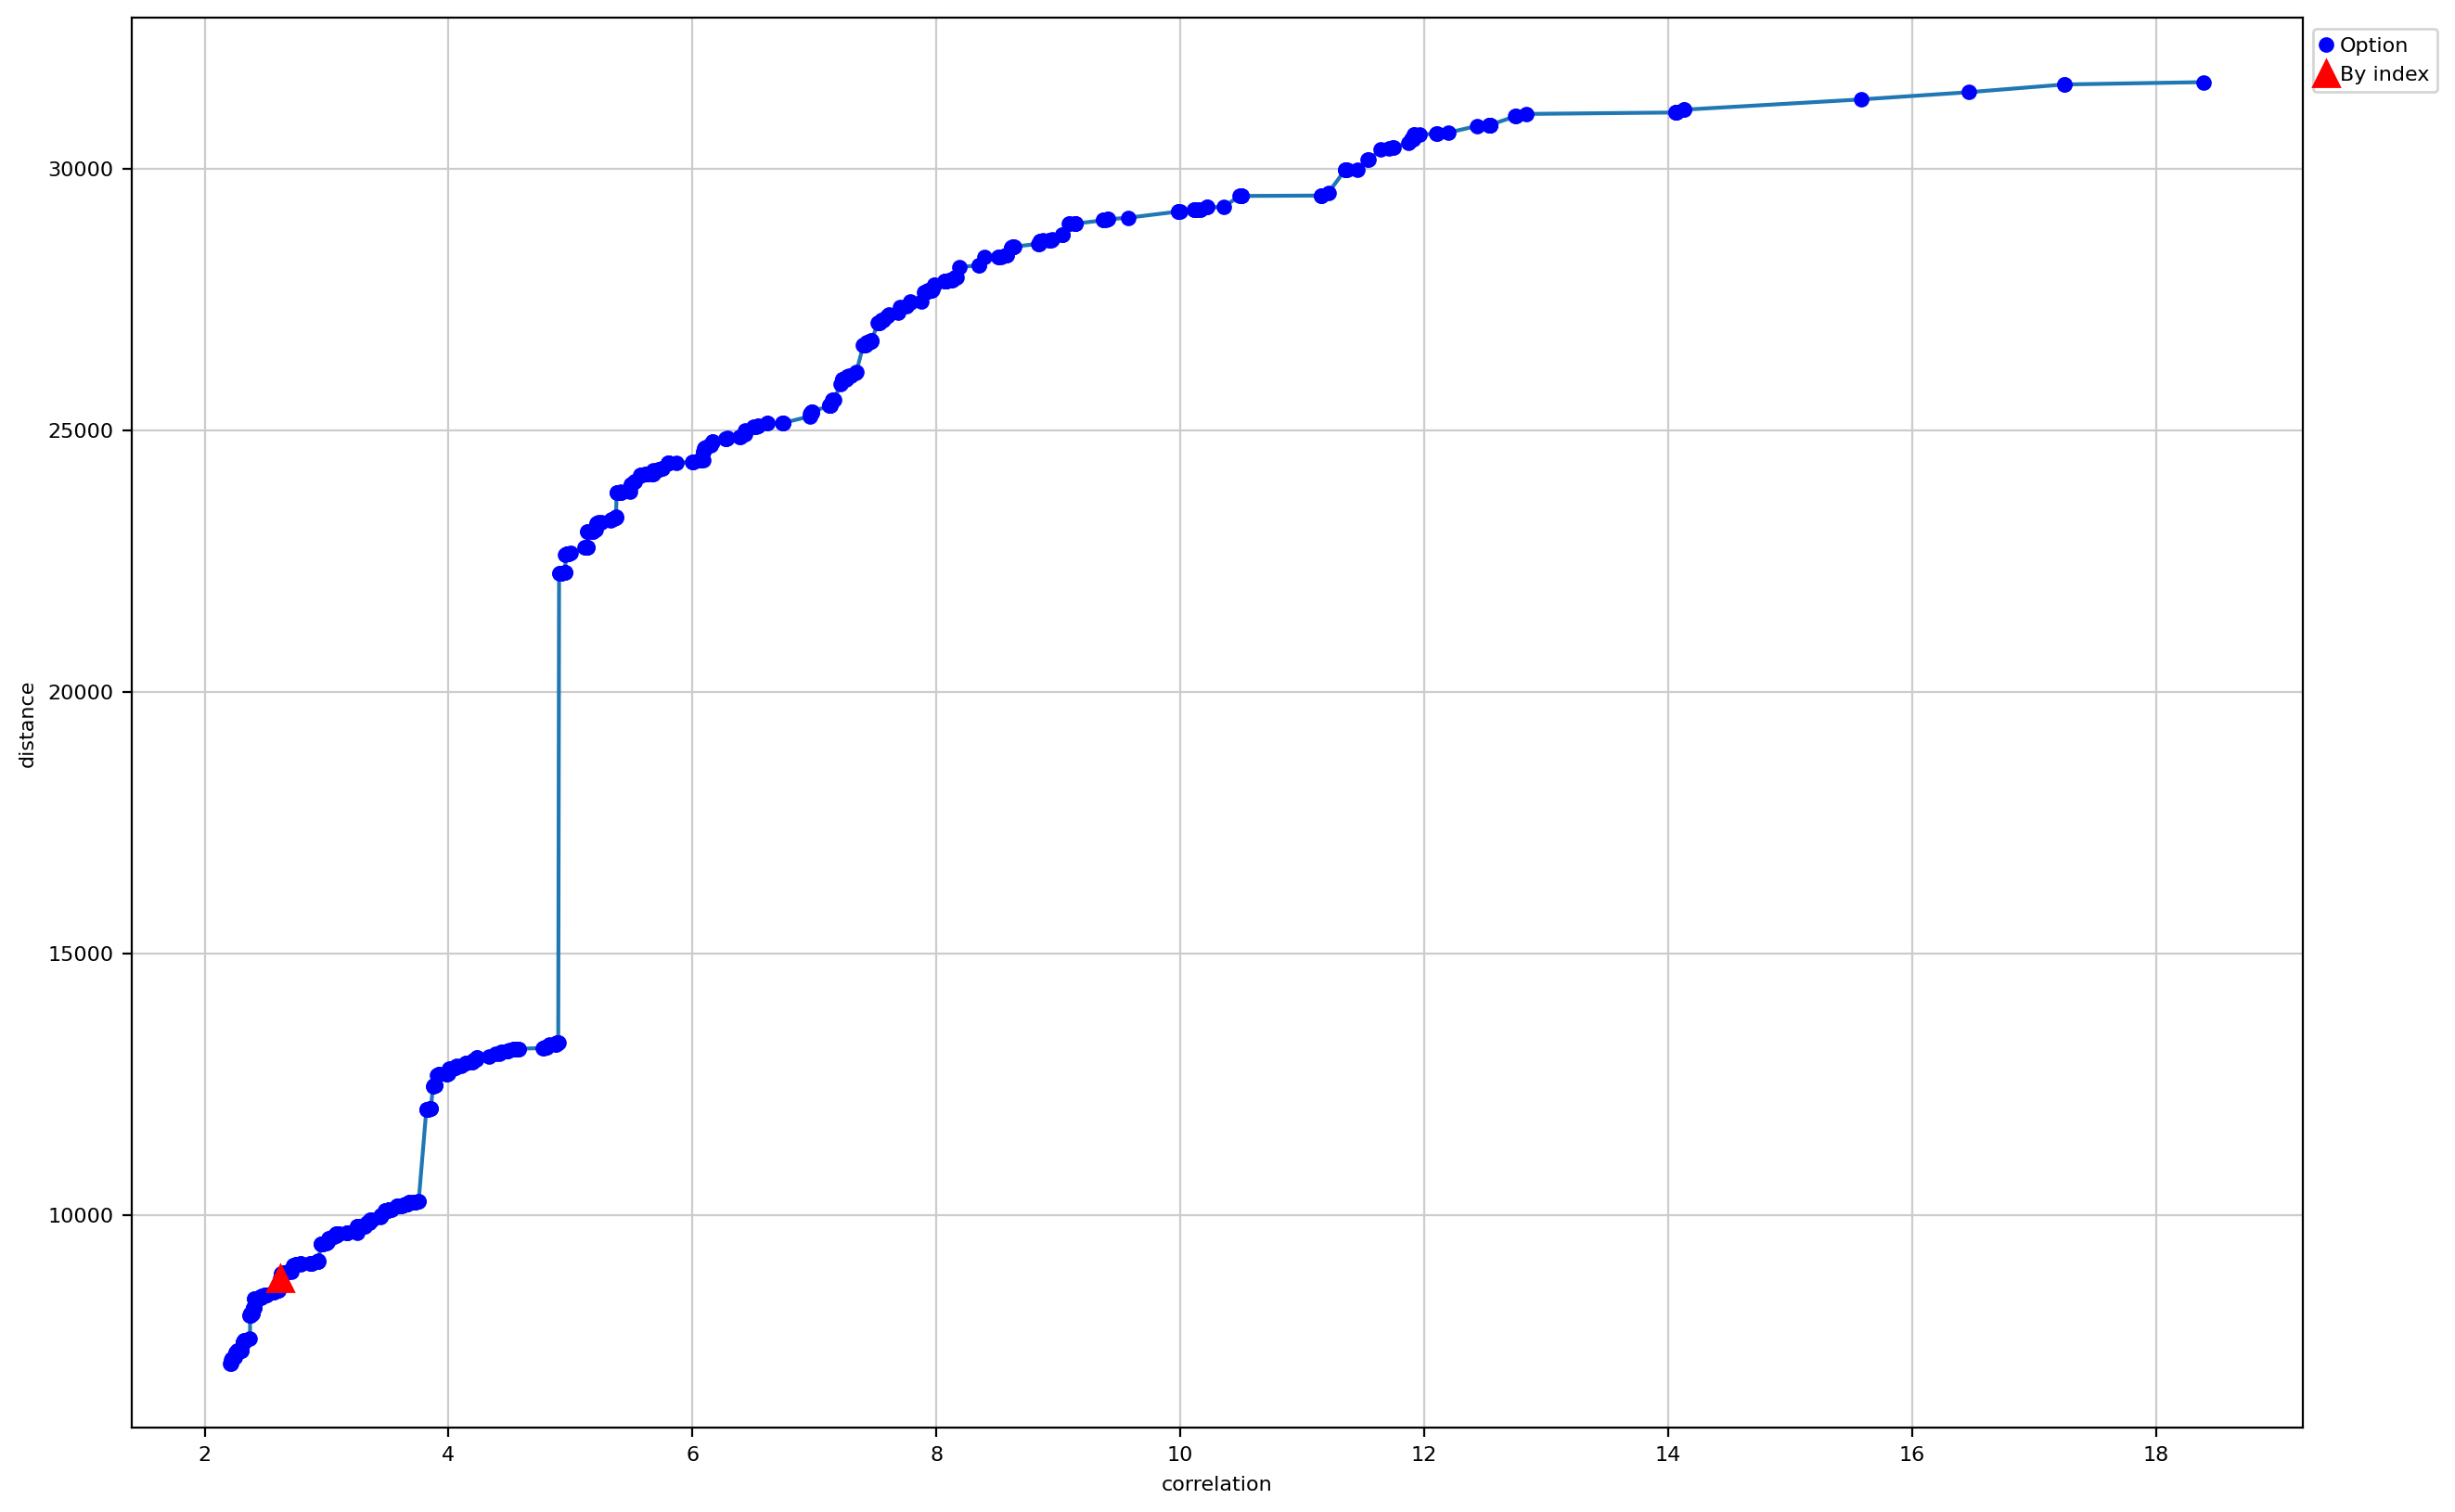

In [24]:
ag.plot(index=100)

In [25]:
pareto =1
selection = ag.select(index=pareto)

centroids_sc_pareto = pd.DataFrame(centroids[:,selection].X.T,index=centroids[:,selection].var_names,columns=centroids[:,selection].obs_names)

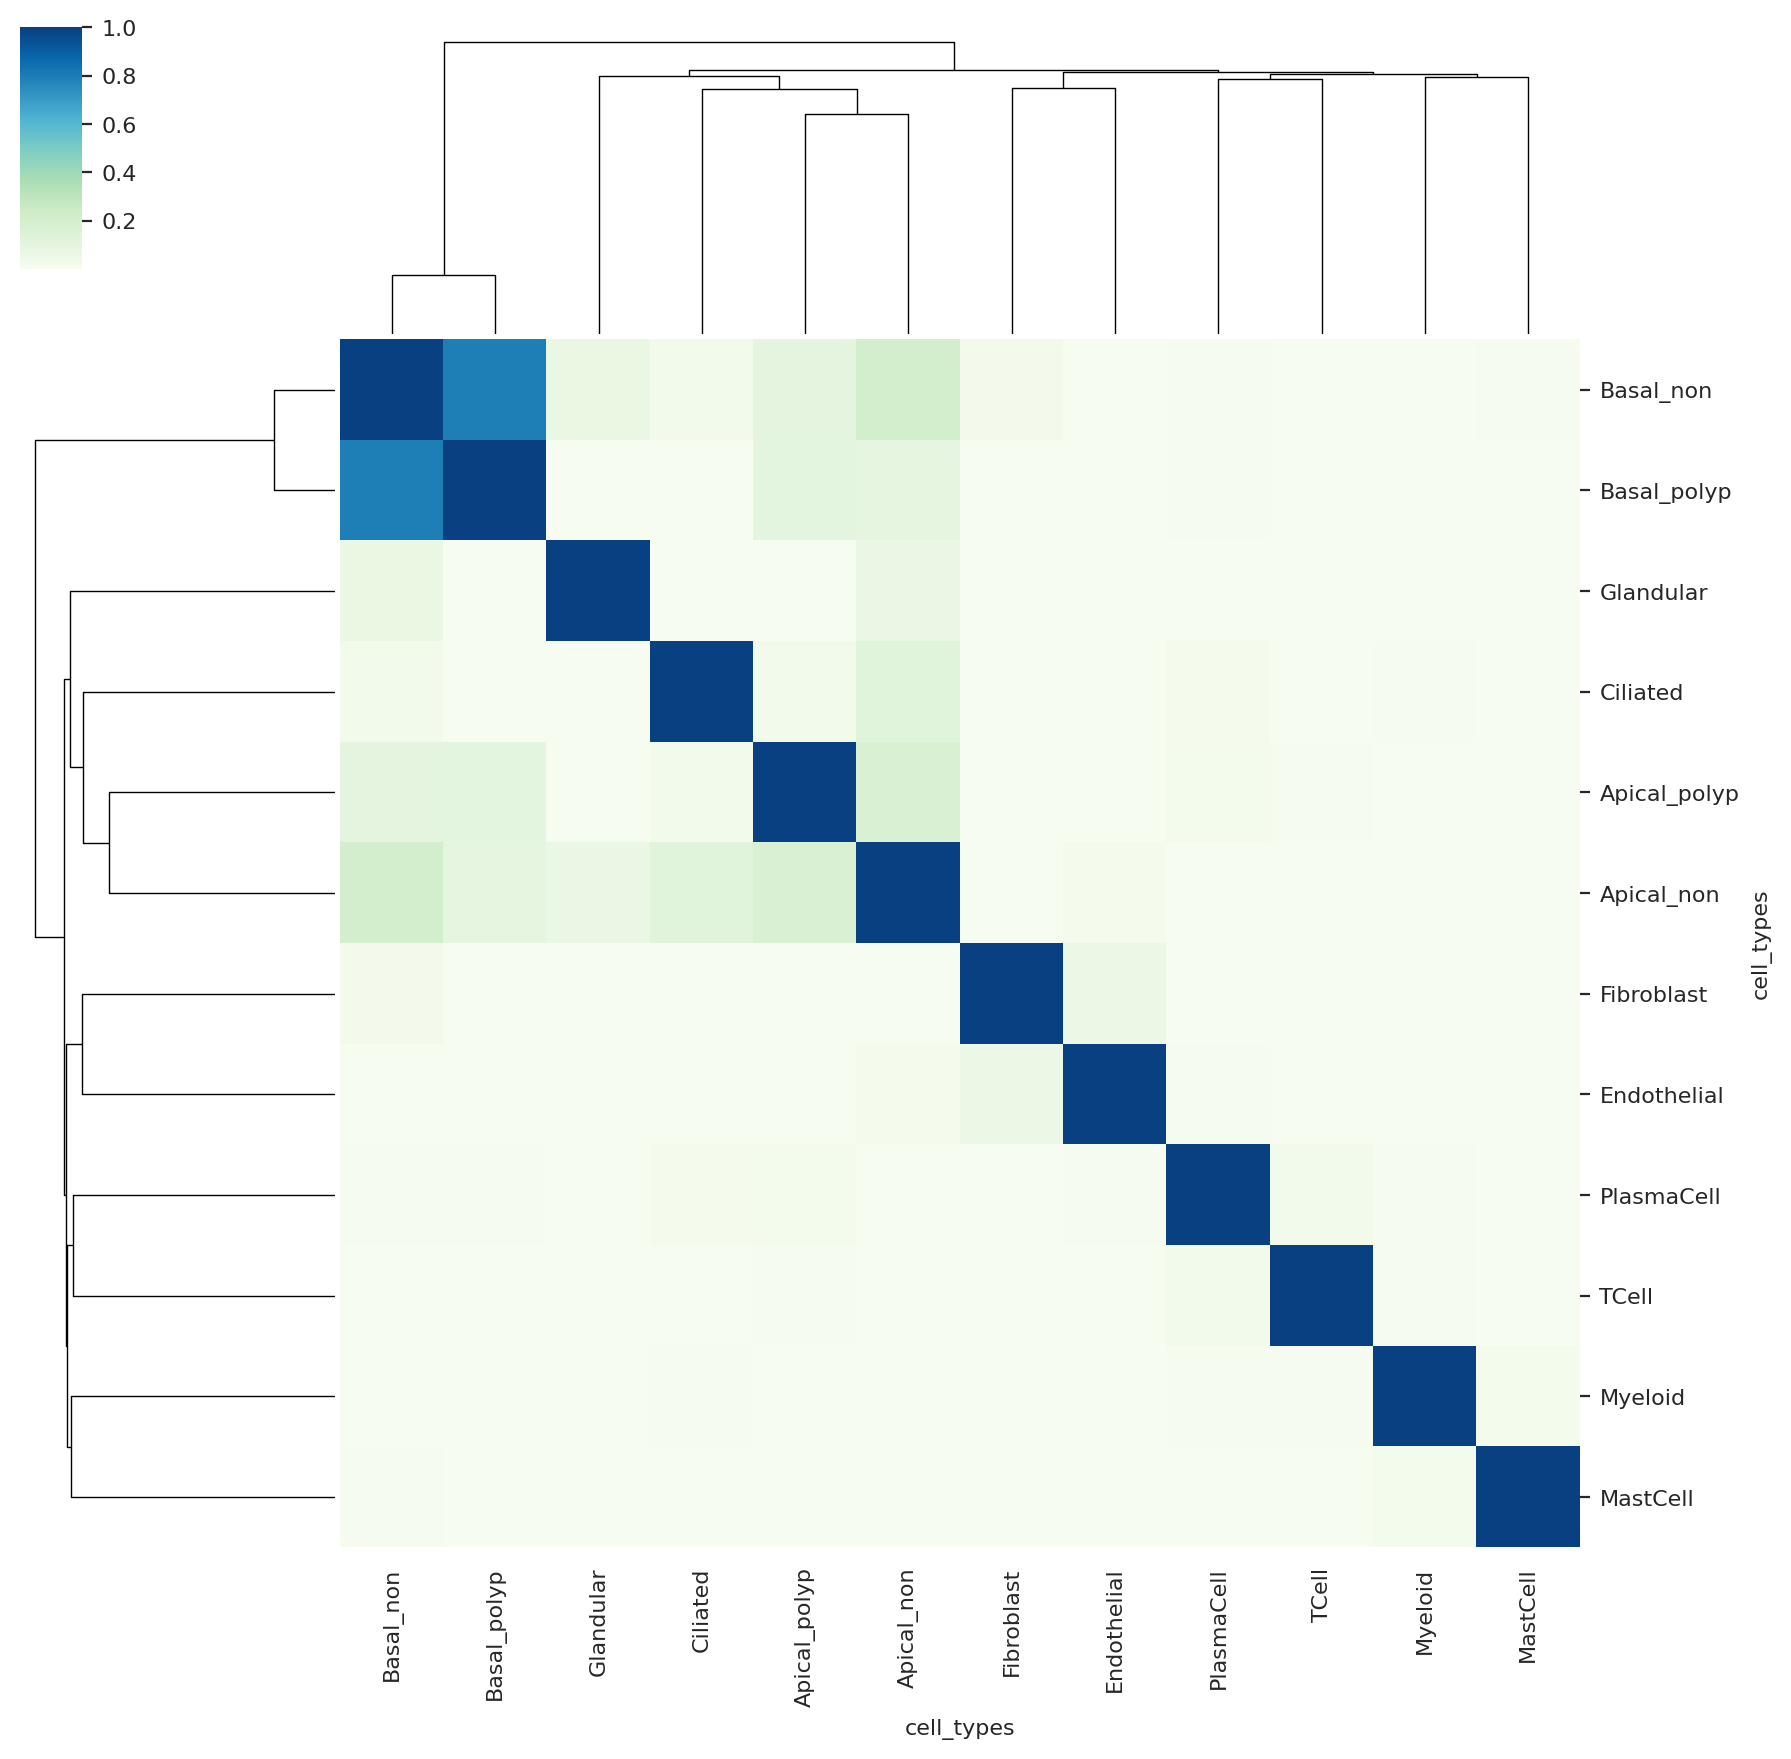

In [26]:
import seaborn as sns
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


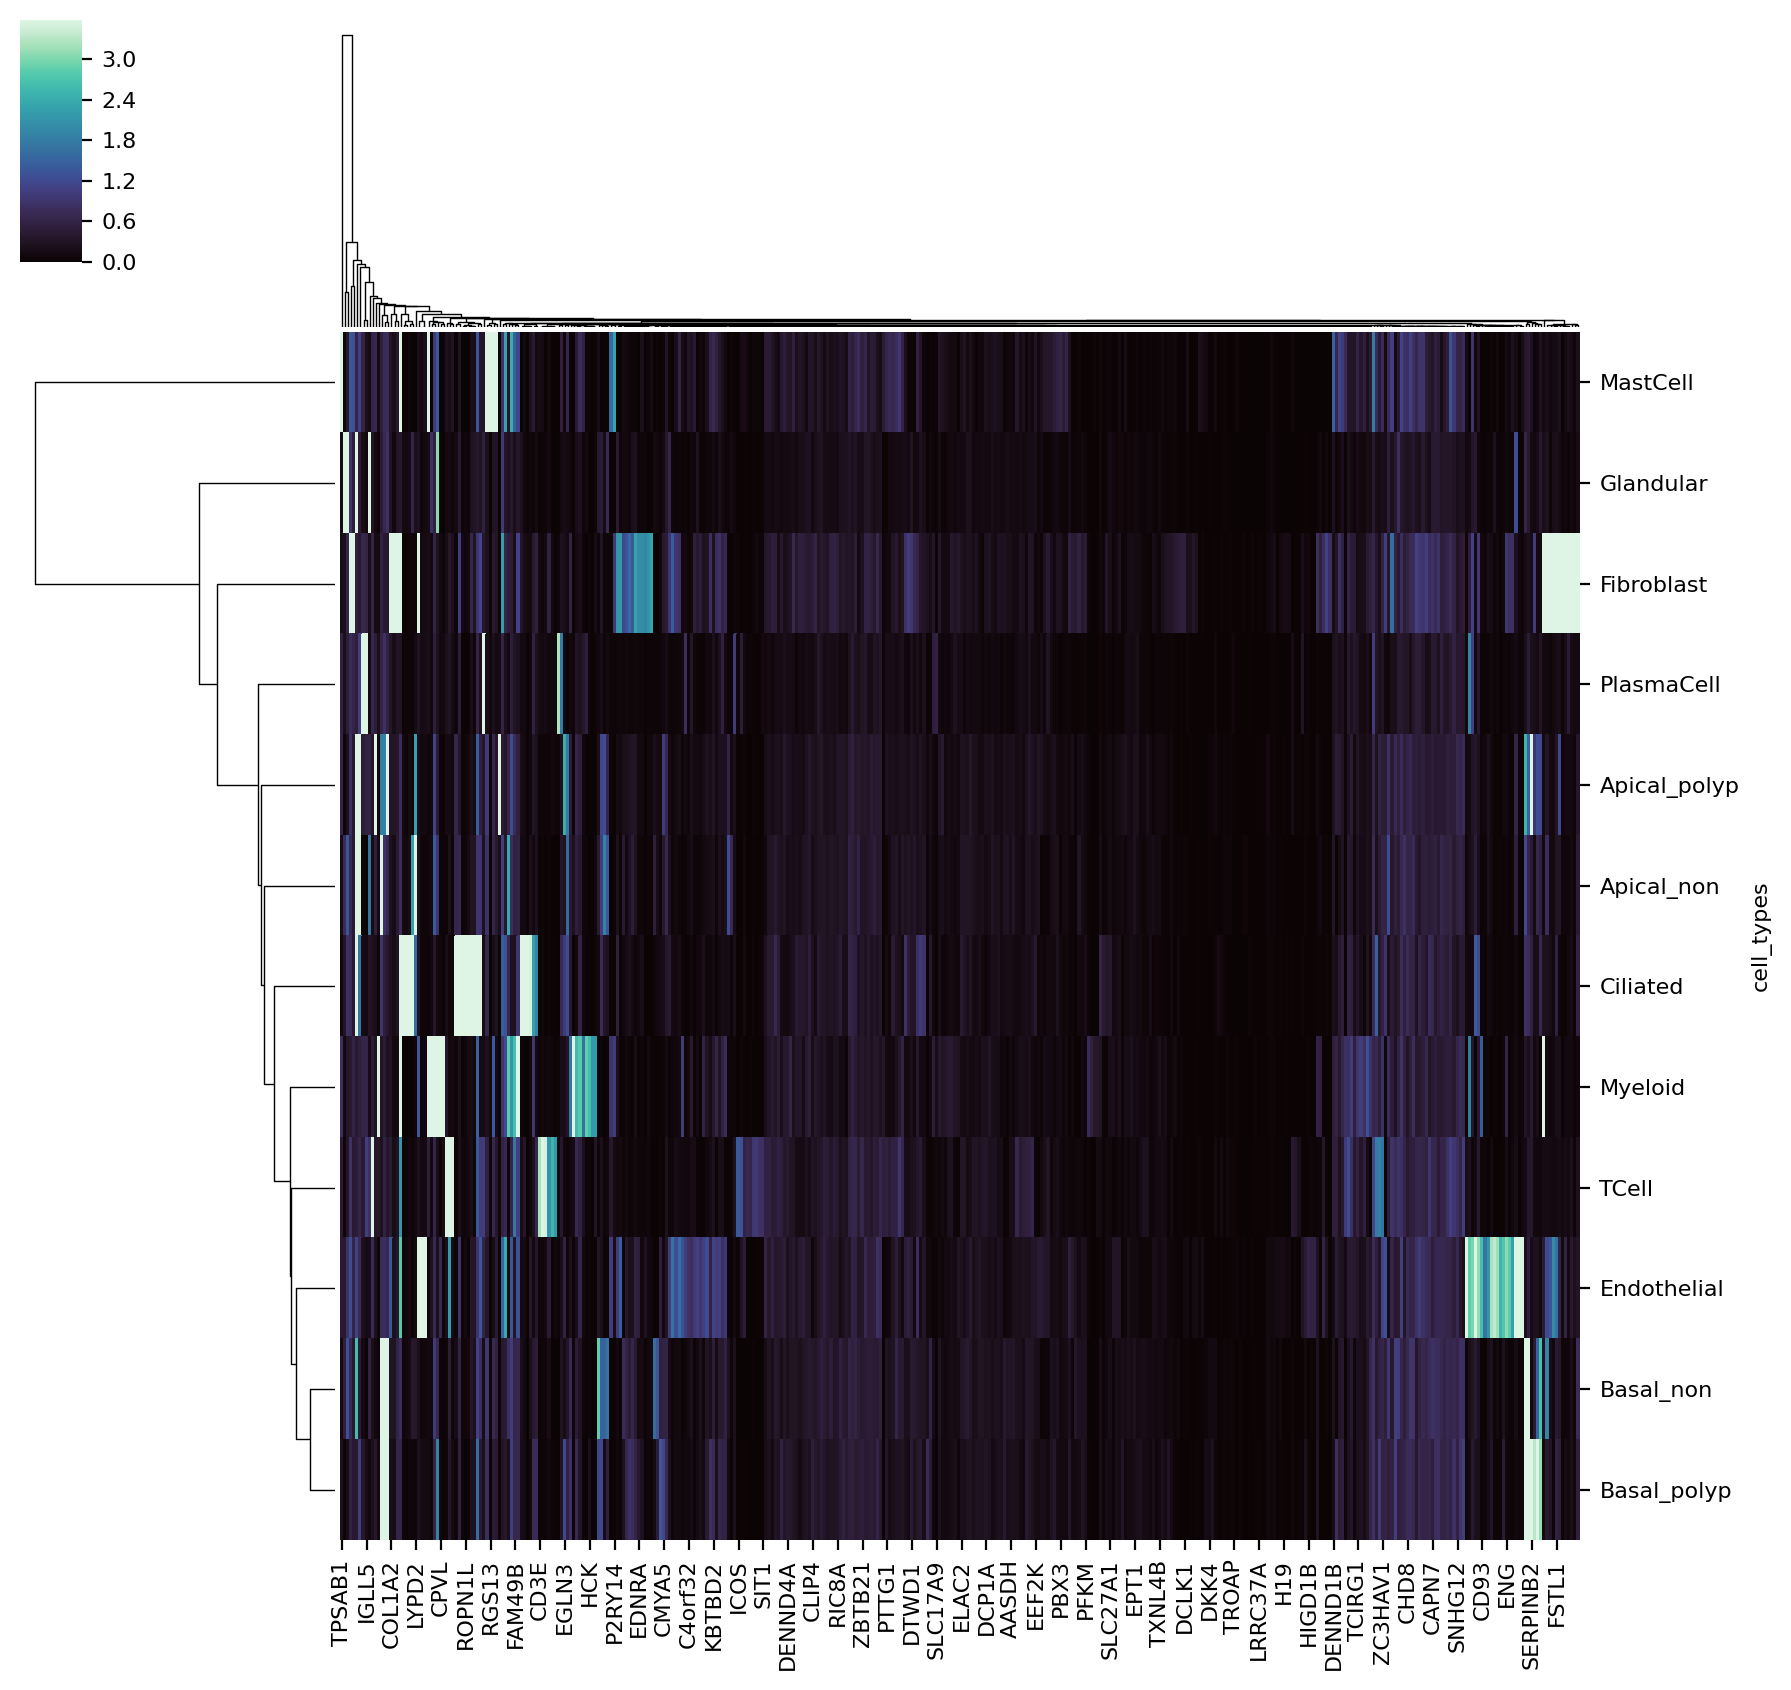

In [27]:
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True) #, cmap="mako", robust=True, row_cluster = False)
#sns_plot.figure.savefig(figdir+"heatmap_GA.png",dpi=300)

In [71]:
n_top_genes = 5000
#centroids_sc_pareto.to_csv('centroids_ethSin_svr_2basal_2apical_louvain9_'+str(ngenes)+'_HV'+str(n_top_genes)+'K_R'+str(ngen)+'_'+str(pareto)+'2.csv')

In [13]:
n_top_genes = 5000
ngenes = 400
ngen = 5000
pareto =1
#centroids_sc_pareto = pd.read_csv('centroids_ethSin_svr_2basal_2apical_louvain9_'+str(ngenes)+'_HV'+str(n_top_genes)+'K_R'+str(ngen)+'_'+str(pareto)+'2.csv',index_col=0)

## Regression

In [44]:
sorted_indicies = np.argsort(abulks_proc.obs['KNNorder'])

In [45]:
abulks_proc_norm = abulks_proc_norm[abulks_proc_norm.obs.iloc[sorted_indicies].index]

In [46]:
abulks_hv = abulks_proc_norm[:,adata_log.var['highly_variable']==True]#[:,shared_hv]

In [17]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum!=0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

In [32]:
abulks_hv.shape

(27, 5000)

In [33]:
coef_nnls = ag.deconvolve(abulks_hv.X, model='nusvr')
coef_nnls.shape

(27, 12)

In [34]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index= centroids_sc_pareto.columns, columns = abulks_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [35]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm=proportions_nnls_norm.astype(float)

In [70]:
n_top_genes = 5000
#proportions_nnls_norm.to_csv('proportions_ethSin_louvain_svr_1basal_2apical_louvain9_'+str(ngenes)+'_HV'+str(n_top_genes)+'K_R'+str(ngen)+'_'+str(pareto)+'2.csv')

In [26]:
#proportions_nnls_norm = pd.read_csv('proportions_ethSin_louvain_svr_1basal_2apical_louvain9_'+str(ngenes)+'_HV'+str(n_top_genes)+'K_R'+str(ngen)+'_'+str(pareto)+'2.csv',index_col=0)

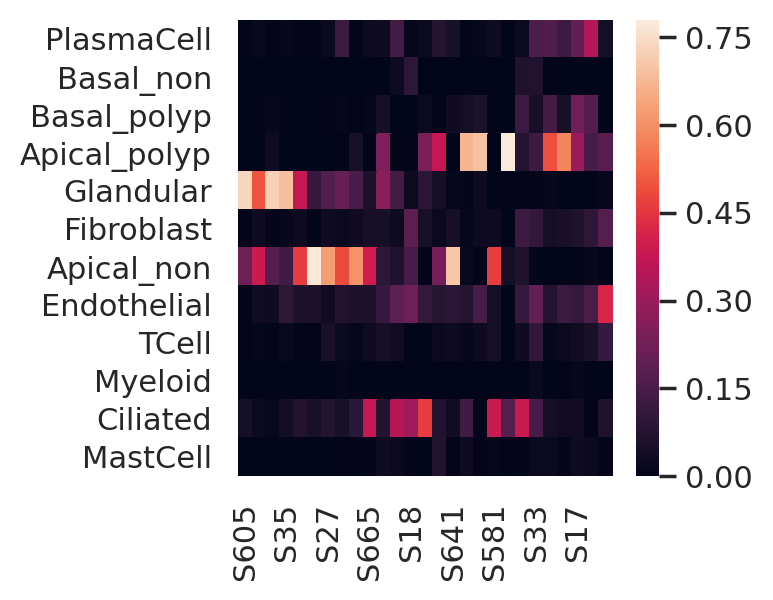

In [56]:
#test = test.drop('sample')
import seaborn as sns; sns.set()
ax = sns.heatmap(proportions_NuSVR.T.astype(float))

In [27]:
#proportions_nnls_norm.index = proportions_nnls_norm.index.add_categories('sample')
proportions_nnls_norm.loc['sample',:] = 'NON-POLYP'
for x in proportions_nnls_norm.columns:
    if abulks_hv.obs.loc[x,'polyp']=='yes':
        proportions_nnls_norm.loc['sample',x] = 'POLYP'

In [28]:
indices_non = [x for x in abulks_proc.obs_names if abulks_proc.obs.loc[x,'polyp']=='no']
indices_pol = [x for x in abulks_proc.obs_names if abulks_proc.obs.loc[x,'polyp']=='yes']


In [29]:
proportions_nnls_norm = proportions_nnls_norm.loc[:,indices_non+indices_pol]
test = proportions_nnls_norm.copy() #test.loc[:,indices_non+indices_pol]
test = test.drop('sample')

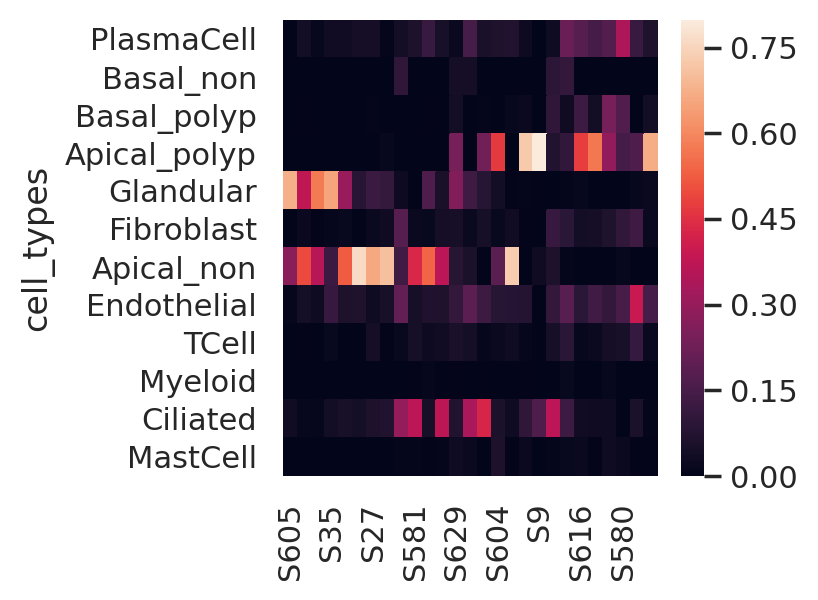

In [30]:
#test = test.drop('sample')
import seaborn as sns; sns.set()
ax = sns.heatmap(test.astype(float))

In [42]:
abulks_proc = abulks_proc[proportions_nnls_norm.columns]

In [112]:
colors = ['olive','olive','olive','olive','olive','olive','olive','olive','olive','olive',
         'maroon','maroon','maroon','maroon','maroon','maroon','maroon','maroon','maroon',
          'maroon','maroon','maroon','maroon','maroon','maroon','maroon','maroon',]

In [44]:
test

S605         S652        S593          S35           S2  \
cell_types                                                                     
PlasmaCell              0    0.0398385   0.0147213     0.035267    0.0371714   
Basal_non               0            0           0            0            0   
Basal_polyp             0   0.00582383           0            0   0.00124377   
Apical_polyp            0            0  0.00107952            0            0   
Glandular        0.673607     0.375546    0.574206     0.652944      0.30453   
Fibroblast    0.000726479    0.0199559  0.00537086    0.0119549     0.017311   
Apical_non       0.277044      0.49643    0.360254     0.123307     0.524817   
Endothelial     0.0105982    0.0422461   0.0291294     0.117287     0.060457   
TCell          0.00265648   0.00520736  0.00239888    0.0178539   0.00188016   
Myeloid                 0            0           0   0.00277023            0   
Ciliated        0.0353682    0.0147007   0.0115946    0.0378533    0.0525706   
MastCell                0  0.000252488  0.00124531  0.000763105  1.94816e-05   

                      S10         S27        S664         S18        S581  \
cell_types                                                                  
PlasmaCell      0.0444708   0.0454075  0.00746726   0.0384028   0.0623118   
Basal_non               0           0           0    0.100886           0   
Basal_polyp    0.00234434   0.0084787           0           0  0.00113364   
Apical_polyp            0           0   0.0145613           0           0   
Glandular        0.086974    0.122438    0.109908   0.0277499           0   
Fibroblast              0    0.021967   0.0324378    0.179268   0.0246288   
Apical_non       0.761964    0.664091    0.705373    0.135399    0.432366   
Endothelial     0.0633463   0.0310981   0.0505694    0.199556   0.0471983   
TCell                   0   0.0458567  0.00614619   0.0155928   0.0485616   
Myeloid                 0           0           0           0  0.00574381   
Ciliated        0.0405558   0.0596353   0.0714824    0.296826     0.36889   
MastCell      0.000345143  0.00102742   0.0020546  0.00631971  0.00916631   

              ...         S41           S9          S3         S33       S616  \
cell_types    ...                                                               
PlasmaCell    ...   0.0272586            0   0.0281329    0.216724   0.179012   
Basal_non     ...           0            0   0.0916182    0.106515          0   
Basal_polyp   ...    0.022242            0    0.102271   0.0336529   0.129028   
Apical_polyp  ...    0.727486     0.798185   0.0686062    0.105728   0.476182   
Glandular     ...  0.00700645   0.00312034           0  0.00826027  0.0155299   
Fibroblast    ...   0.0050724            0    0.116182   0.0888782  0.0387998   
Apical_non    ...           0    0.0328162   0.0594214  0.00655302          0   
Endothelial   ...    0.075466            0    0.106612     0.18548  0.0903508   
TCell         ...     0.01197  0.000521941   0.0483755   0.0893261  0.0139242   
Myeloid       ...  0.00313097            0  0.00252269   0.0162234          0   
Ciliated      ...    0.101513     0.162819    0.368303    0.124854  0.0370107   
MastCell      ...   0.0188544   0.00253837  0.00795519   0.0178045  0.0201623   

                    S628        S17        S580          S1         S19  
cell_types                                                               
PlasmaCell      0.145658   0.173822    0.340246    0.120846   0.0639233  
Basal_non              0          0           0           0           0  
Basal_polyp    0.0383515   0.241634    0.168005           0   0.0376048  
Apical_polyp    0.570884   0.291976    0.144519     0.16256    0.667983  
Glandular              0          0           0   0.0127799   0.0216385  
Fibroblast     0.0458361  0.0647307    0.105542    0.132197   0.0206777  
Apical_non             0          0   0.0132569           0           0  
Endothelial     0.13

Trying to set attribute `.obs` of view, copying.


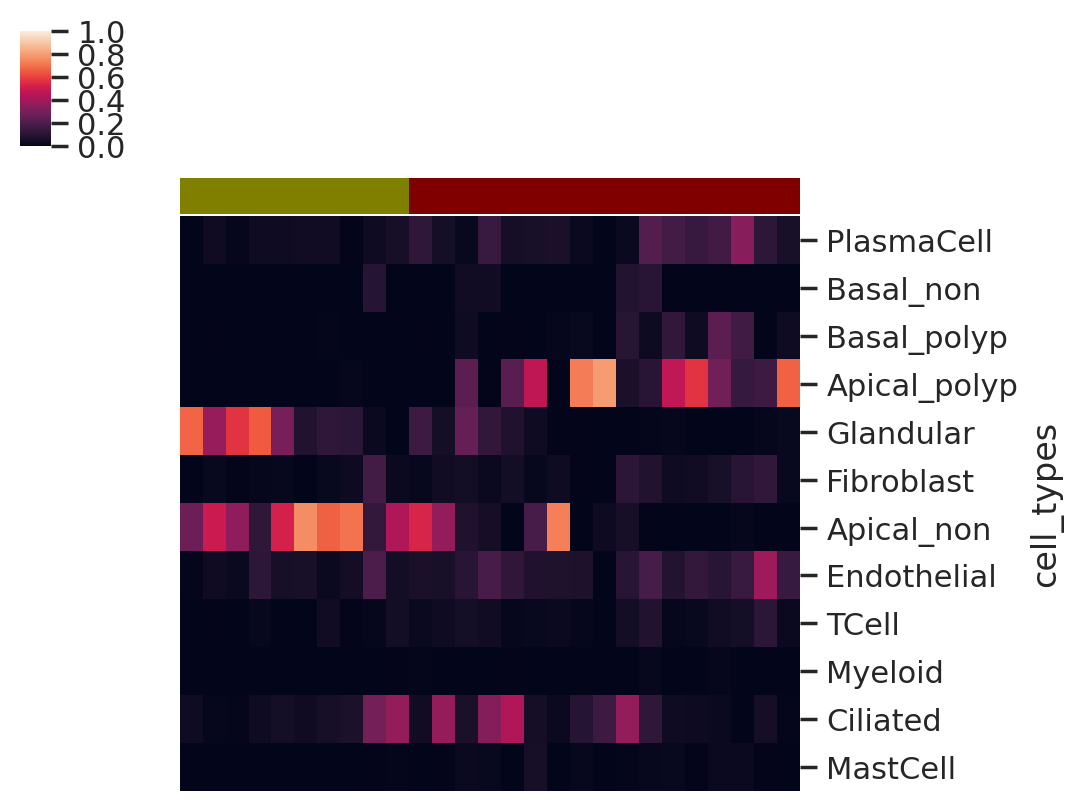

In [45]:
#400
#test = test.drop(['Apical_polyp','Basal_polyp'])
test = test.astype(float)
abulks_proc.obs['sample'] = proportions_nnls_norm.loc['sample',:]
abulks_proc.obs['order'] = np.linspace(1,len(abulks_proc.obs_names),len(abulks_proc.obs_names)).astype('int')
abulks_proc.layers['counts'] = abulks_proc.X
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
ax = sns.clustermap(test.loc[:,abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(5,5),vmax=1)

Trying to set attribute `.obs` of view, copying.


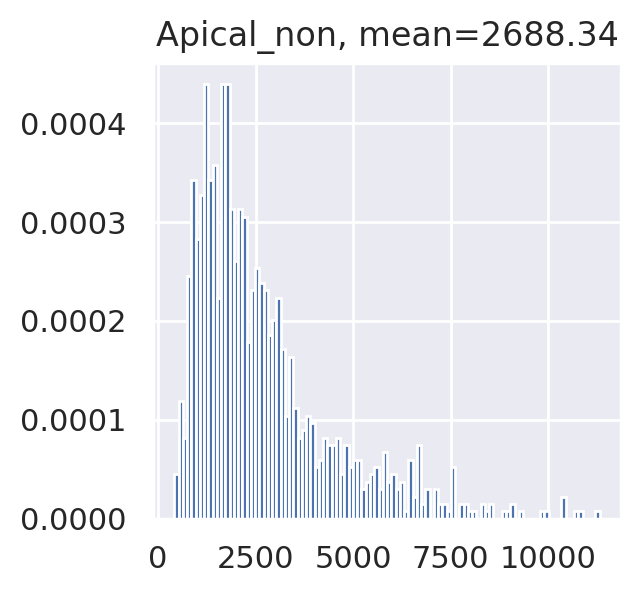

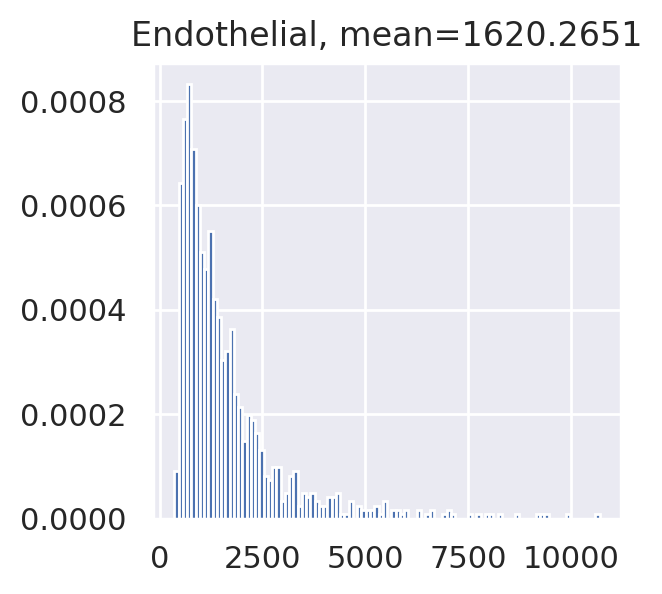

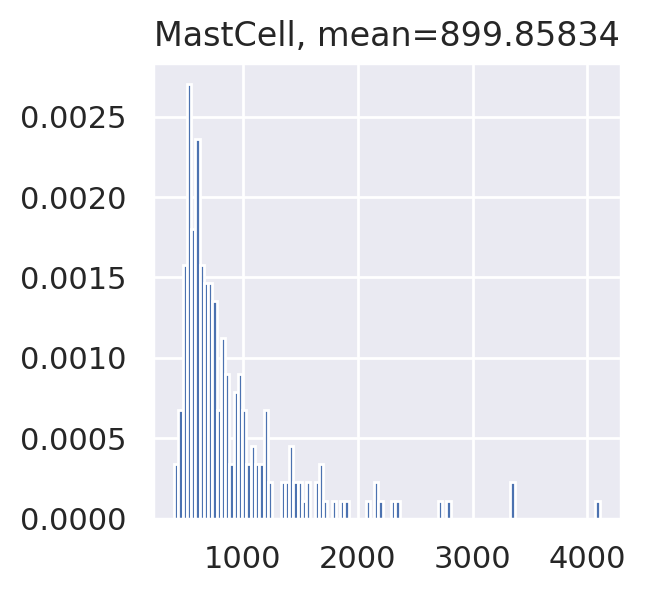

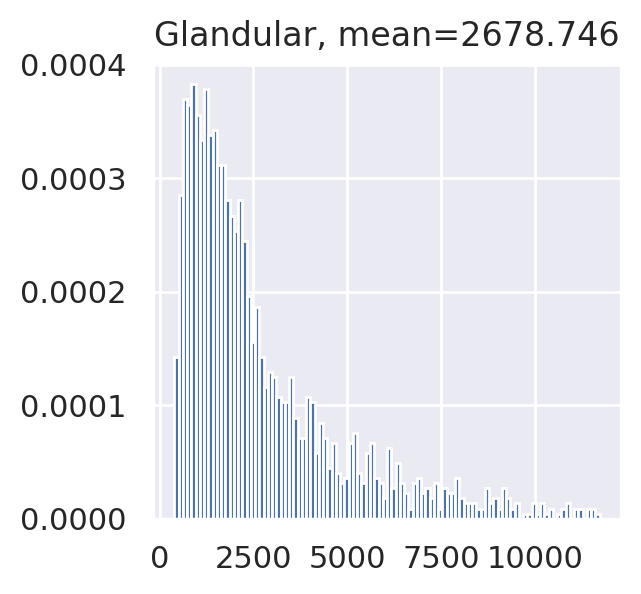

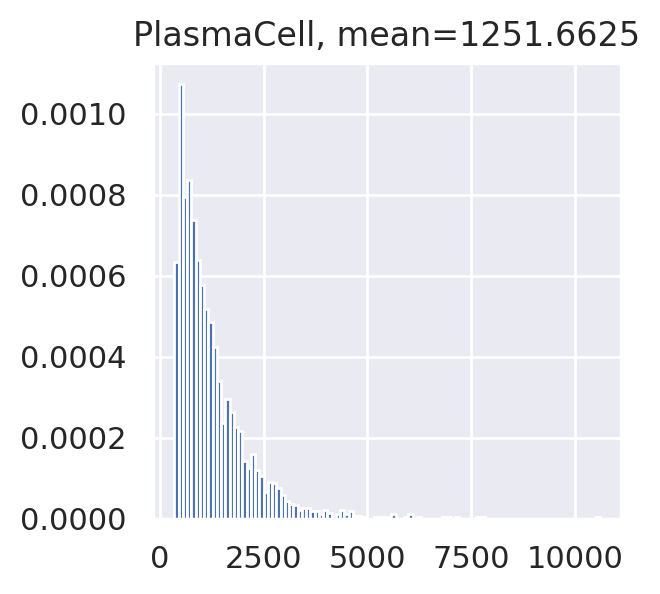

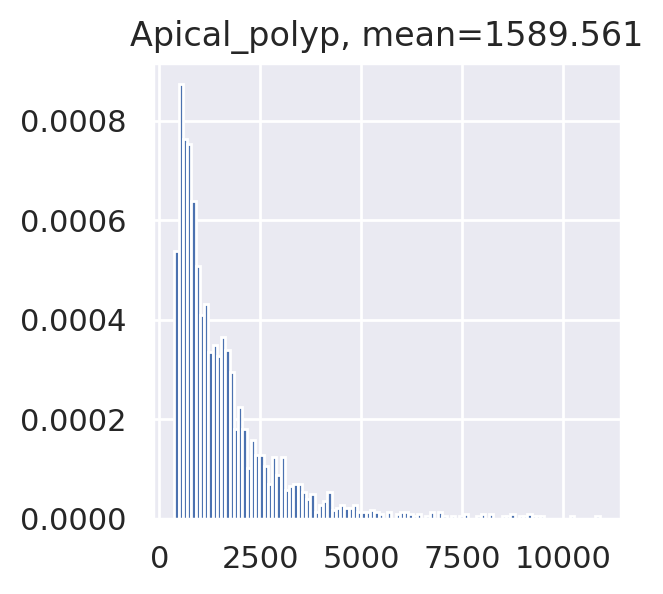

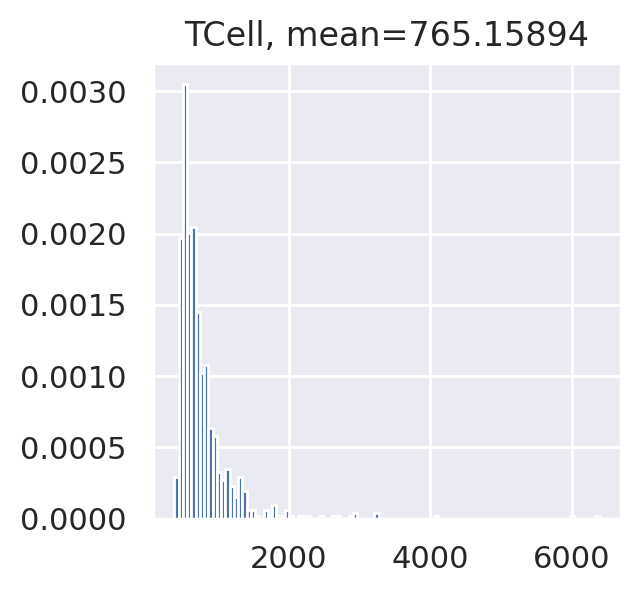

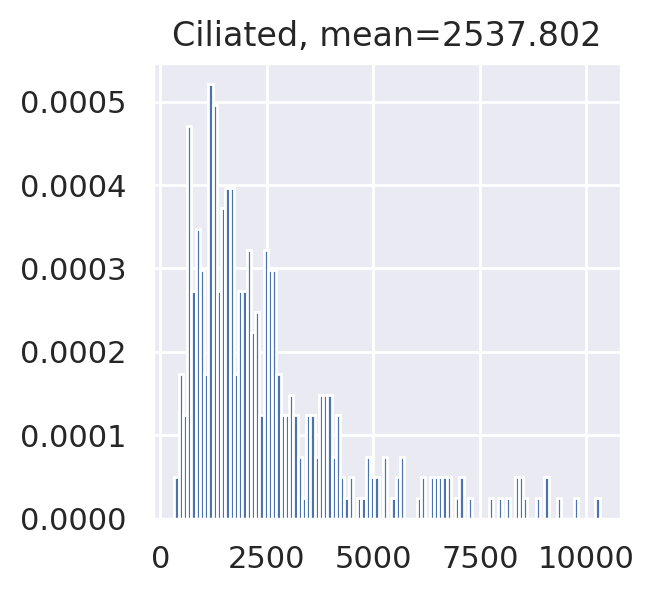

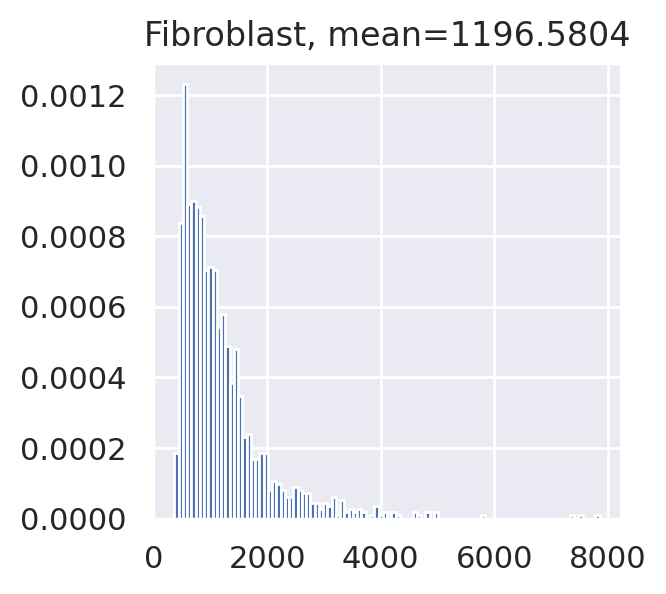

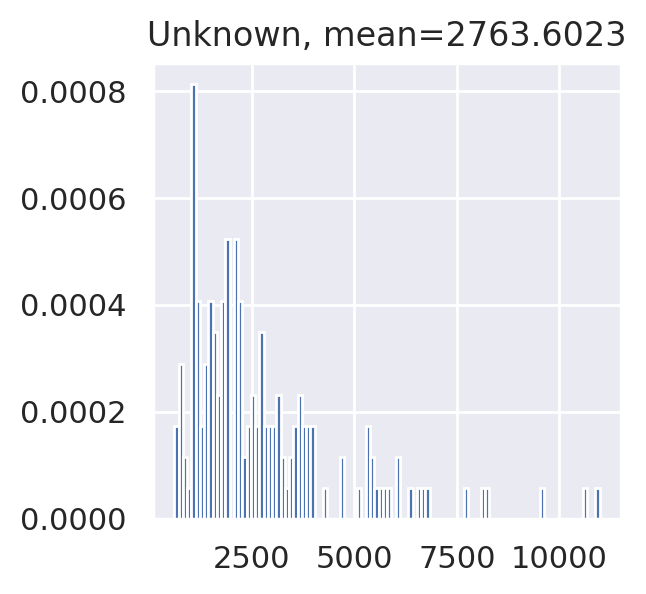

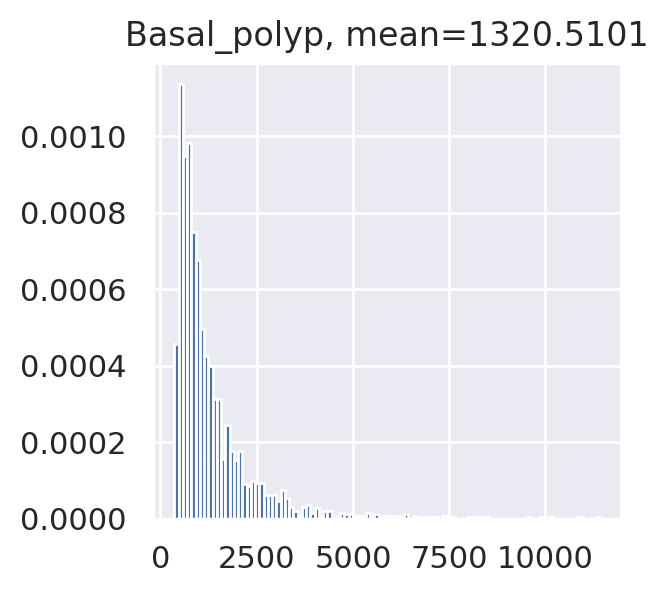

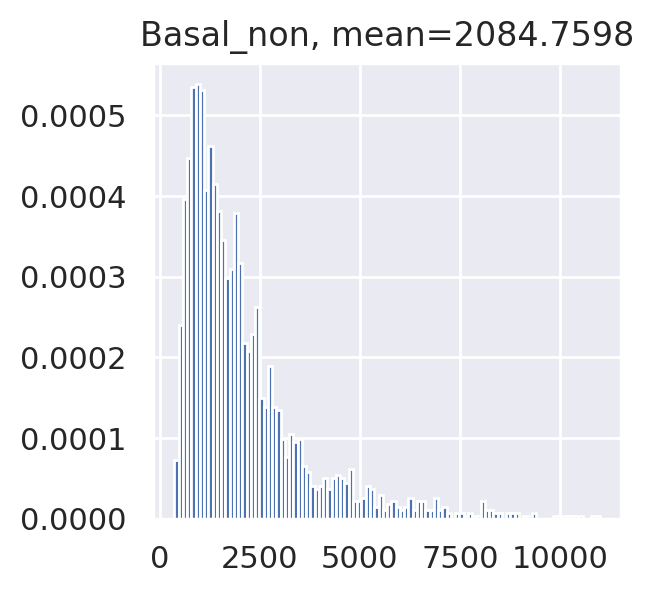

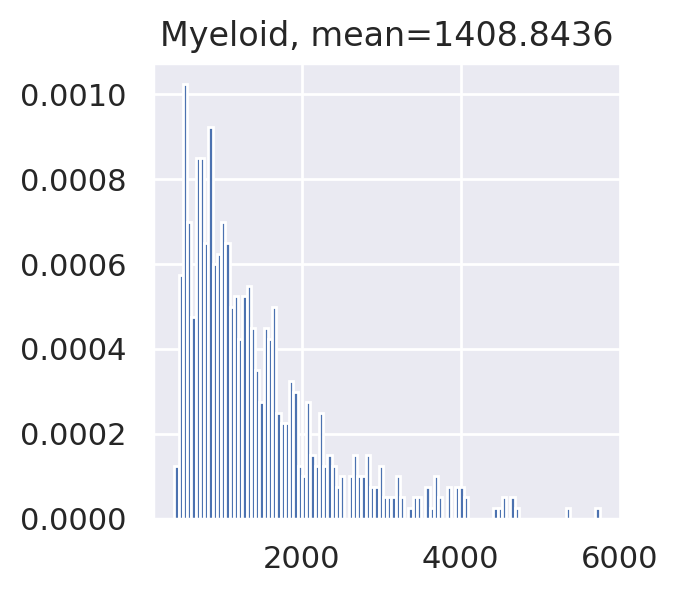

In [46]:
adata_proc.obs['louvain_subset'] = adata_log.obs['louvain_subset']
sc_prob_mean = prob_mean(adata_proc,'louvain_subset')

In [47]:
size = np.sum(sc_prob_mean,axis=0)
size = size.drop('Unknown')
#sc_prob_mean = centroids_sc_pareto.loc[:,size.index]*size

In [48]:
from sklearn.svm import NuSVR
from sklearn import linear_model

abulks_pareto = abulks_proc_norm[:,centroids_sc_pareto.index]
proportions_NuSVR = pd.DataFrame(index=abulks_pareto.obs_names,columns=centroids_sc_pareto.columns)
for s in abulks_hv.obs_names:
    model = NuSVR(nu=0.5,C=0.5,kernel='linear')
    model.fit(sc_prob_mean.loc[centroids_sc_pareto.index,centroids_sc_pareto.columns],np.asarray(abulks_pareto[s].X.T))
    proportions_NuSVR.loc[s] = model.coef_[0]
proportions_NuSVR = normalize_proportions(proportions_NuSVR, copy = True)

In [49]:
proportions_NuSVR = proportions_NuSVR.astype(float)
test2 = proportions_NuSVR.copy()
proportions_NuSVR = proportions_NuSVR.loc[proportions_nnls_norm.columns,:]
#proportions_NuSVR.index = proportions_NuSVR.index.add_categories('sample')
proportions_NuSVR.loc['sample'] = proportions_nnls_norm.loc['sample']
test2 = test2.T

In [50]:
test2

S605      S652      S593       S35        S2       S10  \
cell_types                                                                 
PlasmaCell    0.000000  0.009259  0.003747  0.000000  0.000000  0.003244   
Basal_non     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Basal_polyp   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Apical_polyp  0.000000  0.000000  0.032198  0.000000  0.000000  0.000000   
Glandular     0.649153  0.659982  0.754098  0.514501  0.480524  0.299268   
Fibroblast    0.009824  0.035123  0.014815  0.018396  0.029088  0.005087   
Apical_non    0.175482  0.130548  0.065817  0.197761  0.233114  0.373422   
Endothelial   0.026148  0.057144  0.056880  0.115956  0.087194  0.119116   
TCell         0.002425  0.008857  0.011174  0.020031  0.000000  0.004768   
Myeloid       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Ciliated      0.135867  0.096129  0.050740  0.128755  0.169172  0.189917   
MastCell      0.001100  0.002958  0.010531  0.004599  0.000908  0.005179   

                   S27       S34      S664      S665  ...       S19      S581  \
cell_types                                            ...                       
PlasmaCell    0.008905  0.054240  0.010222  0.039293  ...  0.037511  0.014805   
Basal_non     0.000000  0.000000  0.005583  0.069490  ...  0.000000  0.037953   
Basal_polyp   0.000000  0.017910  0.024081  0.025495  ...  0.094236  0.010178   
Apical_polyp  0.000000  0.000000  0.066078  0.000000  ...  0.258098  0.000000   
Glandular     0.325880  0.310243  0.286600  0.120580  ...  0.079136  0.000000   
Fibroblast    0.050580  0.025498  0.051327  0.074175  ...  0.066147  0.036186   
Apical_non    0.277167  0.244110  0.234253  0.243358  ...  0.029639  0.344162   
Endothelial   0.064098  0.119100  0.097711  0.100539  ...  0.301665  0.072430   
TCell         0.072797  0.032529  0.025619  0.038570  ...  0.042396  0.056717   
Myeloid       0.000000  0.034165  0.000669  0.005886  ...  0.000000  0.007610   
Ciliated      0.187656  0.138527  0.176299  0.235410  ...  0.033886  0.365511   
MastCell      0.012916  0.023678  0.021558  0.047203  ...  0.057287  0.054446   

                    S9        S3       S33      S616      S628       S17  \
cell_types                                                                 
PlasmaCell    0.000000  0.007825  0.058907  0.093611  0.079575  0.064469   
Basal_non     0.000000  0.107144  0.055218  0.000000  0.000000  0.000000   
Basal_polyp   0.000000  0.072069  0.032425  0.092481  0.040332  0.105907   
Apical_polyp  0.317688  0.078109  0.118344  0.240247  0.305782  0.279963   
Glandular     0.001409  0.000000  0.008532  0.031117  0.000000  0.000000   
Fibroblast    0.000000  0.119363  0.094778  0.072265  0.079957  0.070803   
Apical_non    0.259705  0.127627  0.027336  0.000000  0.034354  0.000000   
Endothelial   0.000000  0.104083  0.186942  0.147536  0.207245  0.143800   
TCell         0.014807  0.028708  0.063651  0.022247  0.029923  0.040586   
Myeloid       0.000000  0.000191  0.020818  0.009360  0.000000  0.038532   
Ciliated      0.364124  0.320390  0.254748  0.126837  0.173705  0.103979   
MastCell      0.042268  0.034489  0.078300  0.164299  0.049127  0.151962   

                  S580        S1  
cell_types                        
PlasmaCell    0.145702  0.018354  
Basal_non     0.000000  0.000000  
Basal_polyp   0.105720  0.000000  
Apical_polyp  0.180537  0.150110  
Glandular     0.000000  0.012081  
Fibroblast    0.112022  0.115016  
Apical_non    0.025191  0.000000  
Endothelial   0.235058  0.459588  
TCell         0.062127  0.077455  
Myeloid       0.000000  0.000000  
Ciliated      0.007347  0.151674  
MastCell      0.126296  0.015723  

[12 rows x 27 columns]

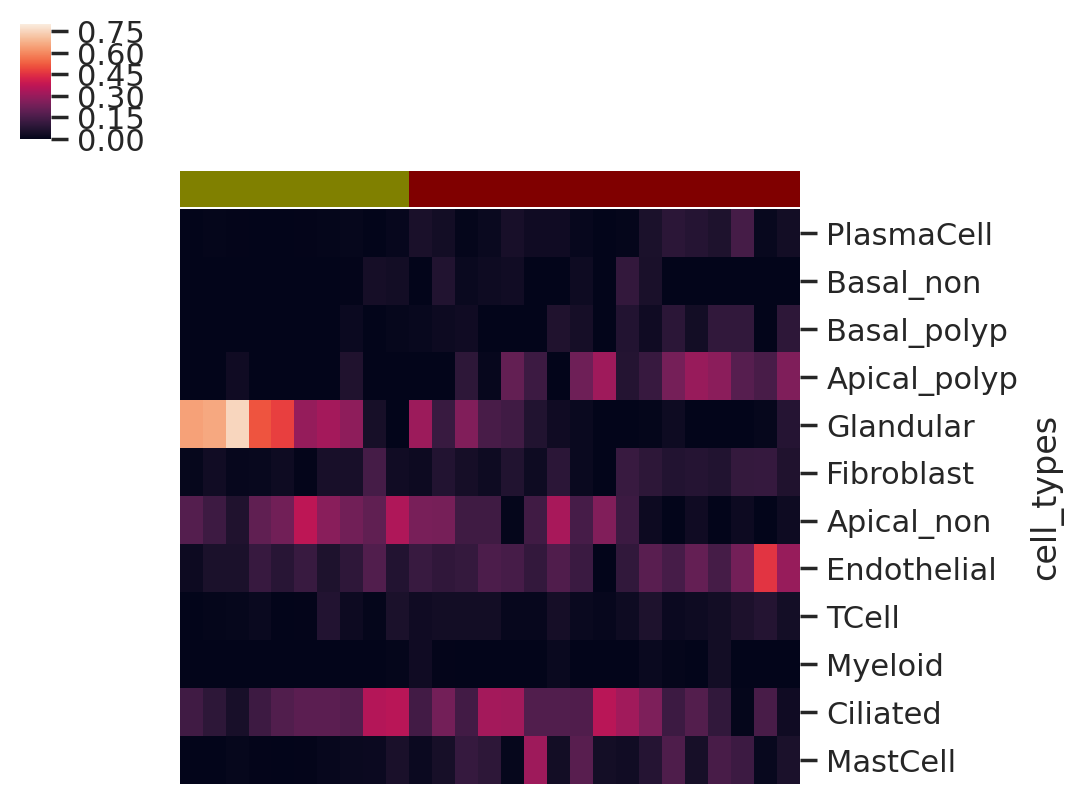

In [51]:
abulks_proc.obs['sample'] = proportions_nnls_norm.loc['sample',:]
abulks_proc.obs['order'] = np.linspace(1,len(abulks_proc.obs_names),len(abulks_proc.obs_names)).astype('int')
abulks_proc.layers['counts'] = abulks_proc.X
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
ax = sns.clustermap(test2.loc[:,abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(5,5),vmax=0.8)

In [72]:
#test2.index = test2.index.add_categories('Apical')
#test2.index = test2.index.add_categories('Basal')
test2.loc['Apical',:] = test2.loc['Apical_non',:]+test2.loc['Apical_polyp',:]
#test2.loc['Basal',:] = test2.loc['Basal_non',:]+test2.loc['Basal_polyp',:]
test2=test2.drop(['Apical_non','Apical_polyp'],axis=0)

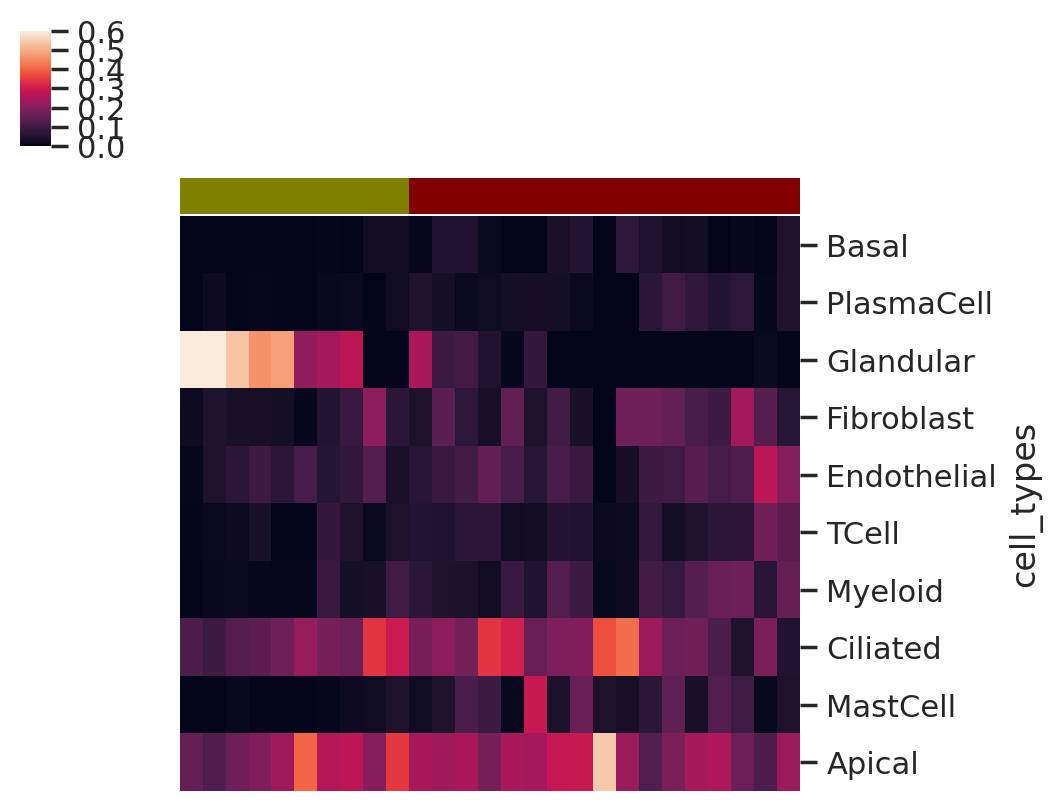

In [74]:
abulks_proc.obs['sample'] = proportions_nnls_norm.loc['sample',:]
abulks_proc.obs['order'] = np.linspace(1,len(abulks_proc.obs_names),len(abulks_proc.obs_names)).astype('int')
abulks_proc.layers['counts'] = abulks_proc.X
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
ax = sns.clustermap(test2.loc[:,abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(5,5),vmax=0.6)

# Data Analysis

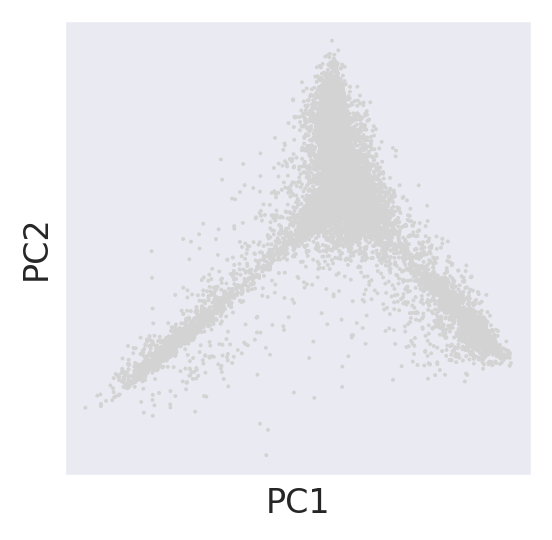

In [52]:
adata_pareto = adata_log[:,centroids_sc_pareto.index].copy()
adata_pareto = adata_pareto[adata_hv.obs_names]
sc.tl.pca(adata_pareto)
adata_pareto.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_pareto)
sc.pp.neighbors(adata_pareto, n_neighbors=20)
sc.tl.umap(adata_pareto)

In [72]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

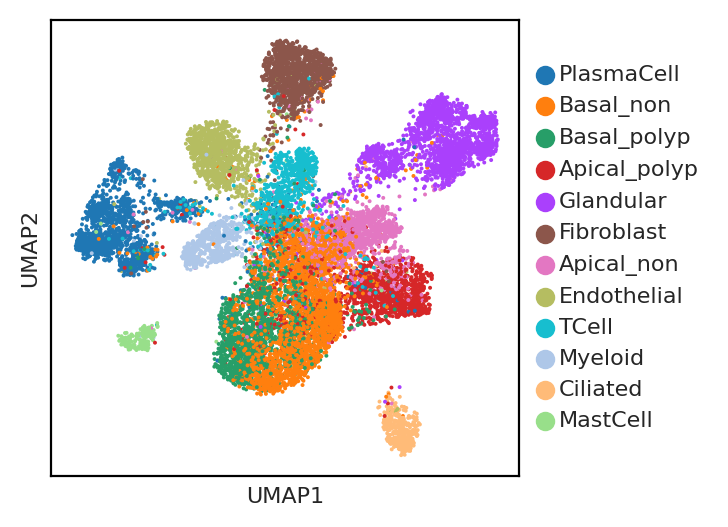

In [73]:
sc.pl.umap(adata_pareto,color='louvain_subset',title='',save='_cell_type_ethsin_pareto.pdf')

In [154]:
import matplotlib.pyplot as plt
def plot_1(x,y,title,figDir):
    s,i,r,p,e = sci.stats.linregress(x,y)
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot(111)
    ax.grid(b=None)
    ax.scatter(x, y, color = 'black',s=5)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y,color='red')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.xlabel("expression of CAPS")
    plt.ylabel("proportion of ciliated cells")
    plt.grid(color='w')
    plt.title(title)
    #ax.figure(figsize=(5,5))
    ax.text(0.8, 0.1,'r='+str(round(r,2)), ha='center', va='center', transform=ax.transAxes,size=15)
    #plt.show()
    ax.get_figure().savefig(figDir, dpi=100)
    return r,p

In [155]:
import matplotlib.pyplot as plt
def plot_2(x,y,x1,y1,x2,y2,title,figDir,gene,cluster):
    #plt.style.use('seaborn')
    s,i,r,p,e = sci.stats.linregress(x,y)
    s1,i1,r1,p1,e1 = sci.stats.linregress(x1,y1)
    s2,i2,r2,p2,e2 = sci.stats.linregress(x2,y2)
    
    f = plt.figure(figsize=(7,7))
    ax = f.add_subplot(111)
    ax.grid(b=None)
    ax.scatter(x, y, color = 'black',s=28,marker ='o')
    ax.scatter(x1, y1, color = 'black',s=28,marker='x')
    ax.scatter(x2, y2, color = 'black',s=28,marker ='o',facecolors='none')
    plt.legend(['AutoGeneS, r='+str(round(r,2)),'CIBERSORTx, r='+str(round(r1,2)),'MuSiC, r='+str(round(r2,2))],fontsize=17,frameon=False)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y,color='red')
    
    #x1 = np.linspace(np.min(x1), np.max(x1), 1000)
    #y1=x1*s1+i1
    #ax.plot(x1,y1,color='red')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.xlabel("expression of "+gene, fontsize=19)
    plt.ylabel("proportion of "+cluster+" cells", fontsize=19)
    plt.grid(color='w')
    plt.title(title)
    ax.set_facecolor('white')
    ax.axis("on")
    #ax.text(0.8, 0.1,'r='+str(round(r,2)), ha='center', va='center', transform=ax.transAxes,size=15)
    #plt.show()
    ax.get_figure().savefig(figDir, dpi=100)
    return r,p

In [125]:
cibersort = pd.read_csv(data_file+'CIBERSORTx_ethsin_2basal_2apical.txt',sep='\t',index_col=0).T
cibersort = cibersort.drop(['P-value','Correlation','RMSE'],axis=0)
cibersort = cibersort.loc[:,proportions_nnls_norm.columns]
#cibersort.loc['sample',:]=proportions_nnls_norm.loc['sample',:]

In [126]:
music = pd.read_csv(data_file+'music_ethsin.csv',sep=';',index_col=0).T
music = music.loc[:,proportions_nnls_norm.columns]
#music.loc['sample',:]=proportions_nnls_norm.loc['sample',:]

In [127]:
#proportions_nnls_norm = proportions_nnls_norm.astype(float)
cibersort = cibersort.astype(float)
music = music.astype(float)

In [147]:
ciliated = list(proportions_nnls_norm.T.loc[:,'Ciliated'])
ciliated = [float(x) for x in ciliated]
ciliated_ciber = list(cibersort.T.loc[:,'Ciliated'])
ciliated_music = list(music.T.loc[:,'Ciliated'])

In [148]:
glandular = list(proportions_nnls_norm.T.loc[:,'Glandular'])
glandular = [float(x) for x in glandular]
glandular_ciber = list(cibersort.T.loc[:,'Glandular'])
glandular_music = list(music.T.loc[:,'Glandular'])

In [150]:
basal = list(proportions_nnls_norm.T.loc[:,'Basal_polyp'].astype(float)+proportions_nnls_norm.T.loc[:,'Basal_non'].astype(float))
basal = [float(x) for x in basal]
basal_ciber = list(cibersort.T.loc[:,'Basal_polyp']+cibersort.T.loc[:,'Basal_non'])
basal_music = list(music.T.loc[:,'Basal'])

In [152]:
sec = list(proportions_nnls_norm.T.loc[:,'Apical_polyp'].astype(float)+proportions_nnls_norm.T.loc[:,'Apical_non'].astype(float))
sec = [float(x) for x in sec]
sec_ciber = list(cibersort.T.loc[:,'Apical_polyp']+cibersort.T.loc[:,'Apical_non'])
sec_music = list(music.T.loc[:,'Apical'])

In [122]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

In [109]:
abulks_proc.layers['counts'] = abulks_proc.X#sc.pp.scale(abulks_log,copy=True).X
abulks_proc = abulks_proc[proportions_nnls_norm.columns]#ax.mask.columns]
abulks_proc.obs['order'] = np.linspace(1,len(abulks_proc.obs_names),len(abulks_proc.obs_names)).astype('int')

basal_markers = ['KRT5','TSC22D1','KRT15','S100A2','DST','ALDH3A2','MIR205HG','CLDN1','TP63','KRT17',
                 'RASSF6','CYR61','ETS2','ADH7','MPZL2','BCAM','SLC6A6','PDPN','TNC','SFN',
                 'LAMB3','NTRK1','NTRK2','SPINK5']
#secretory_markers = ['VMO1','LYPD2','PSCA','SCGB1A1','S100P','MSMB','ALCAM','KRT7','KRT8','MGST1',
#                     'MUC5AC','SPDEF','LCN2','CLDN7','PI3','SLC31A1','GABRP','TMEM213','STEAP4','GDF15',
#                     'S100A14','MSLN','SORD','NTS','MUC16']
#,'ST6GALNAC1','SLC9A3R1','MUC1','CST1','CST4','IGFBP3','SLC6A14','CST2','CDH26','EGLN3','POR']

secretory_markers = ['WFDC2','LGALS3''VMO1','TSPAN1','AGR2','S100A6','PIGR','TMSB4X','CD55','HLA-B','SAT1','C15orf48',
                      'S100A9','S100A8','MUC4','ANKRD36C','RNA28S5','LCN2','CEACAM6','CEACAM5','MUC1']
ciliated_markers = ['CAPS','C9orf24','PIFO','TPPP3','C20orf85','SNTN','FAM183A','C11orf88','RSPH1','CAPSL',
                   'TMEM190','C1orf194','MORN2','RP11-356K23.1','SPA17','C9orf116','ZMYND10','ROPN1L','LRRIQ1',
                    'DNAH12','C5orf49','CCDC146','C1orf173','TCTEX1D4']
glandular_markers = ['LTF','ZG16B','STATH','AZGP1','TCN1','C6orf58','DMBT1','PIP','RP11-1143G9.4','ODAM',
                     'FDCSP''LPO','MUC5B','SCGB3A1','CCL28','CA2','NDRG2','SLC12A2','LRRC26','HP','PART1',
                     'PPP1R1B','CLDN10','S100A1']

Trying to set attribute `.obs` of view, copying.


In [72]:
shared_markers = [x for x in list(secretory_markers+basal_markers+ciliated_markers+glandular_markers) if x in adata_log.var_names]

In [116]:
adata_log_markers = adata_log[:,centroids_sc_pareto.index].copy()
sc.tl.rank_genes_groups(adata_log_markers, groupby='louvain_subset', key_added='rank_subset')
mg = []
clusters = set(adata_log_markers.obs['louvain_subset'])
markers_subset = pd.DataFrame(columns = clusters)
list_mg = []
for clust in ['Apical_non','Apical_polyp','Basal_non','Basal_polyp','Ciliated','Glandular']:
    mg=adata_log_markers.uns['rank_subset']['names'][clust][:10]
    list_mg.extend(mg)
    markers_subset.loc[:,clust] = mg

In [117]:
markers = list(adata_log_markers.uns['rank_subset']['names']['Apical_non'][:5])+list(adata_log_markers.uns['rank_subset']['names']['Apical_polyp'][:5])+list(adata_log_markers.uns['rank_subset']['names']['Basal_non'][:5])+list(adata_log_markers.uns['rank_subset']['names']['Basal_polyp'][:5])+list(adata_log_markers.uns['rank_subset']['names']['Ciliated'][:5])+list(adata_log_markers.uns['rank_subset']['names']['Glandular'][:5])

In [118]:
adata_log_markers = adata_log[:,list(dict.fromkeys(markers))].copy()
adata_log_markers = adata_log_markers[adata_log_markers.obs['louvain_subset'].isin(['Apical_non','Apical_polyp','Basal_non','Basal_polyp','Ciliated','Glandular'])]
adata_log_markers = adata_log_markers[adata_log_markers.obs.loc[adata_log_markers.obs["louvain_subset"].str.lower().sort_values().index].index]
adata_log_markers.obs['order'] = np.linspace(1,len(adata_log_markers.obs_names),len(adata_log_markers.obs_names)).astype('int')
adata_log_markers.layers['counts'] = adata_log_markers.X

Trying to set attribute `.obs` of view, copying.


['LYPD2', 'MSMB', 'GSTA1', 'CHP2', 'KCNE3', 'CST1', 'CST4', 'CST2', 'EGLN3', 'SERPINB2', 'KRT5', 'CLDN1', 'MIR205HG', 'SPINK5', 'CLCA4', 'KRT15', 'MMP10', 'LAMB3', 'C9orf24', 'C20orf85', 'SNTN', 'TUBA1A', 'LTF', 'TCN1', 'C6orf58', 'CXCL3']


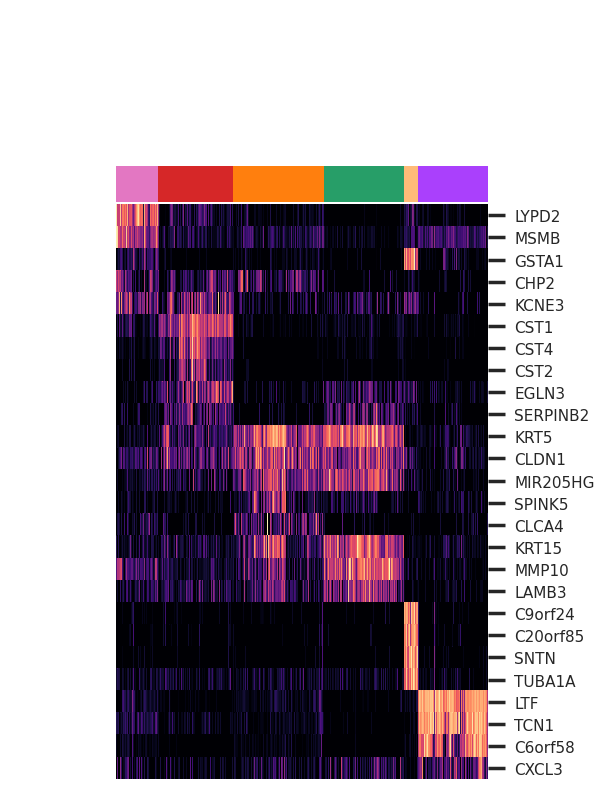

In [119]:
heatmap(adata_log_markers,
        var_names=adata_log_markers.var_names,
        xkey='counts', tkey='order', n_convolve=10,sort=False,
        col_color='louvain_subset',yticklabels=1, font_scale=.5, figsize=(3, 5),save="_all_sc_pareto.png")

['LYPD2', 'MSMB', 'GSTA1', 'CHP2', 'KCNE3', 'CST1', 'CST4', 'CST2', 'EGLN3', 'SERPINB2', 'KRT5', 'CLDN1', 'MIR205HG', 'SPINK5', 'CLCA4', 'KRT15', 'MMP10', 'LAMB3', 'C9orf24', 'C20orf85', 'SNTN', 'TUBA1A', 'LTF', 'TCN1', 'C6orf58', 'CXCL3']
saving figure to file ./figures/scvelo_heatmap__all_autogenes.png


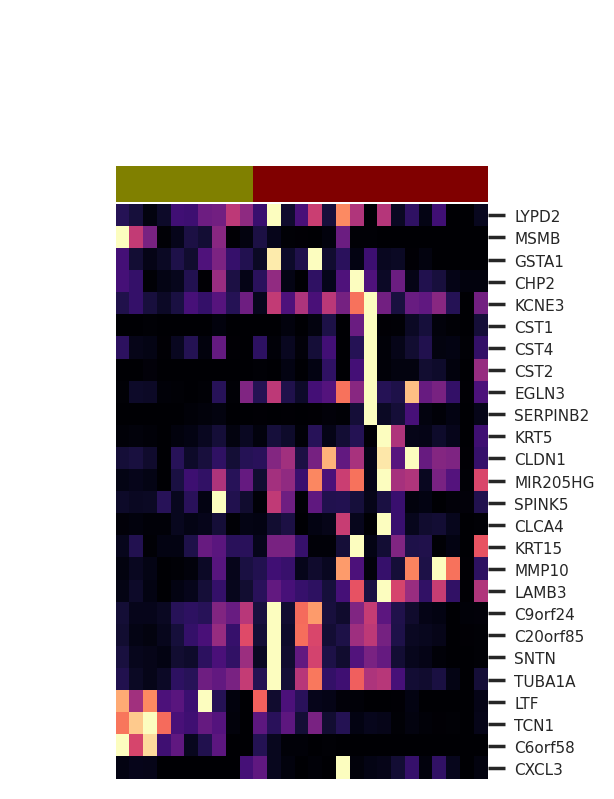

In [186]:
heatmap(abulks_proc,
        var_names=adata_log_markers.var_names,
        xkey='counts', tkey='order', n_convolve=1,sort=False,
        col_color=colors,yticklabels=1, font_scale=.5, figsize=(3, 5),save="_all_autogenes.png")

['WFDC2', 'TSPAN1', 'AGR2', 'S100A6', 'PIGR', 'TMSB4X', 'CD55', 'HLA-B', 'SAT1', 'C15orf48', 'S100A9', 'S100A8', 'MUC4', 'LCN2', 'CEACAM6', 'CEACAM5', 'MUC1', 'KRT5', 'TSC22D1', 'KRT15', 'S100A2', 'DST', 'ALDH3A2', 'MIR205HG', 'CLDN1', 'TP63', 'KRT17', 'RASSF6', 'CYR61', 'ETS2', 'ADH7', 'MPZL2', 'BCAM', 'SLC6A6', 'PDPN', 'TNC', 'SFN', 'LAMB3', 'NTRK1', 'NTRK2', 'SPINK5', 'CAPS', 'C9orf24', 'PIFO', 'TPPP3', 'C20orf85', 'SNTN', 'FAM183A', 'C11orf88', 'RSPH1', 'CAPSL', 'TMEM190', 'C1orf194', 'MORN2', 'SPA17', 'C9orf116', 'ZMYND10', 'ROPN1L', 'LRRIQ1', 'DNAH12', 'C5orf49', 'CCDC146', 'C1orf173', 'TCTEX1D4', 'LTF', 'ZG16B', 'STATH', 'AZGP1', 'TCN1', 'C6orf58', 'DMBT1', 'PIP', 'ODAM', 'MUC5B', 'SCGB3A1', 'CCL28', 'CA2', 'NDRG2', 'SLC12A2', 'LRRC26', 'HP', 'PART1', 'PPP1R1B', 'CLDN10', 'S100A1']
saving figure to file ./figures/scvelo_heatmap__all.png


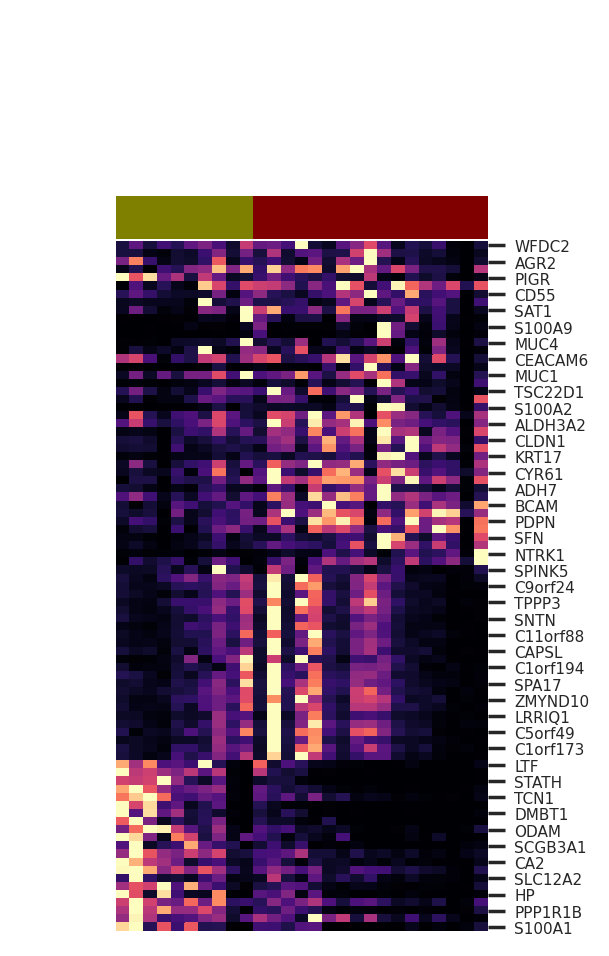

In [224]:
heatmap(abulks_proc,
        var_names=list(secretory_markers+basal_markers+ciliated_markers+glandular_markers),
        xkey='counts', tkey='order', n_convolve=1,sort=False,
        col_color=colors,yticklabels=2, font_scale=.5, figsize=(3, 6),save="_all.png")

In [145]:
abulks_proc.obs['sample'] = proportions_nnls_norm.loc['sample',:]

In [146]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

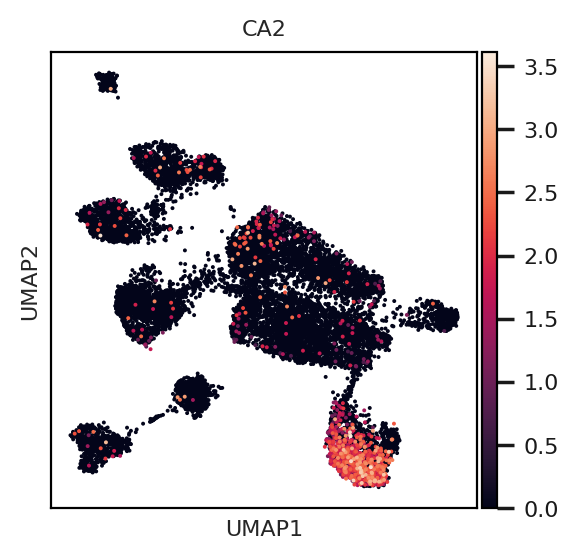

In [147]:
sc.pl.umap(adata_log[adata_hv.obs_names], color='CA2',save='_CA2')


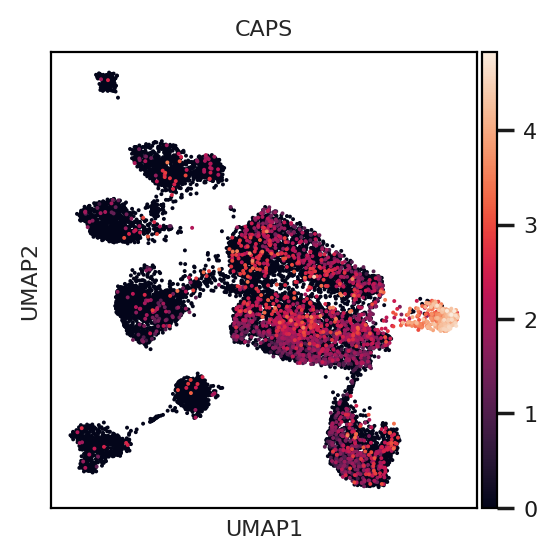

In [148]:
sc.pl.umap(adata_log[adata_hv.obs_names], color='CAPS',save='_CAPS')


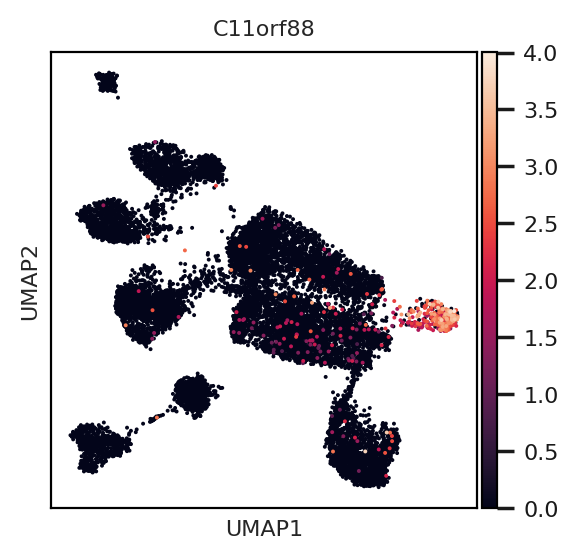

In [179]:
sc.pl.umap(adata_log[adata_hv.obs_names], color='C11orf88',save='_C11orf88')


In [166]:
ordered_cells = ['Apical_non','Apical_polyp','Basal_non','Basal_polyp','Ciliated','Endothelial','Fibroblast','Glandular','MastCell','Myeloid','PlasmaCell','TCell']

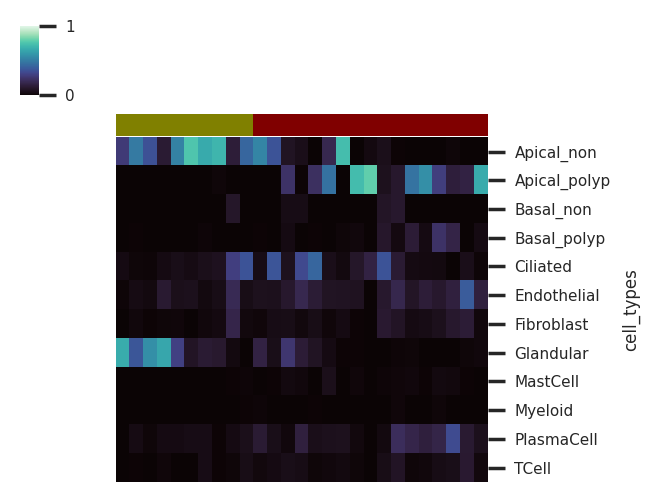

In [225]:
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
test = proportions_nnls_norm.drop(['sample'])
sns_plot = sns.clustermap(test.loc[ordered_cells,abulks_proc.obs_names].astype(float), col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,3),cmap="mako",vmin = 0.0, vmax=1.0, cbar_kws={"ticks":[0,1]})
sns_plot.savefig("prop_autogenes_all.png")

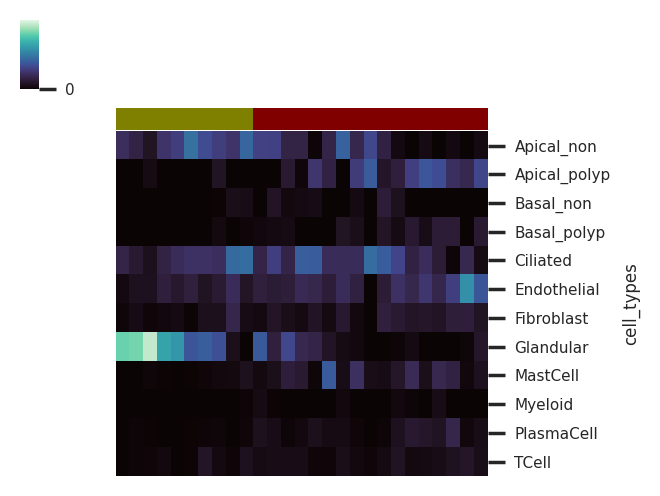

In [226]:
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
test = proportions_nnls_norm.drop(['sample'])
sns_plot = sns.clustermap(test2.loc[ordered_cells,abulks_proc.obs_names].astype(float), col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,3),cmap="mako",vmin = 0.0, vmax=0.8, cbar_kws={"ticks":[0,1]})
sns_plot.savefig("prop_autogenes_all_corrected.png")

In [231]:
cibersort = cibersort.astype(float)

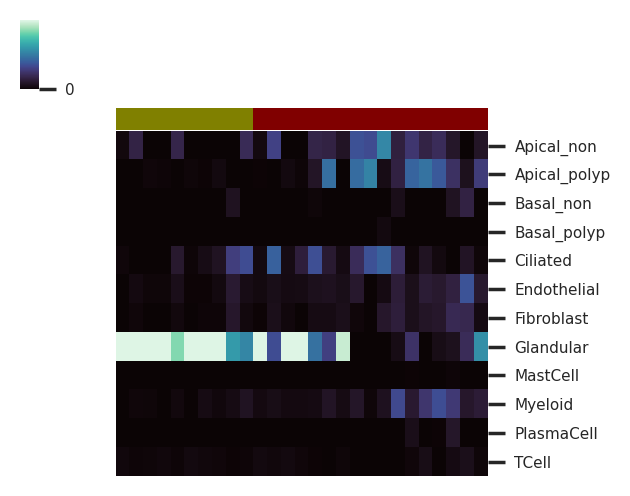

In [232]:
sns.set(font_scale=0.5)
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]

sns_plot = sns.clustermap(cibersort.loc[ordered_cells,abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,3),cmap="mako",vmin = 0.0, vmax=0.8, cbar_kws={"ticks":[0,1]})
sns_plot.savefig("prop_cibersort_all.png")

In [129]:
cibersort_sum = cibersort.loc[['Apical_non','Basal_polyp','Ciliated','Endothelial','Fibroblast','Glandular','MastCell','Myeloid','PlasmaCell','TCell'],:]
cibersort_sum.index = ['Apical','Basal','Ciliated','Endothelial','Fibroblast','Glandular','MastCell','Myeloid','PlasmaCell','TCell']
cibersort_sum.loc['Basal'] = cibersort.loc['Basal_non']+cibersort.loc['Basal_polyp']
cibersort_sum.loc['Apical'] = cibersort.loc['Apical_non']+cibersort.loc['Apical_polyp']

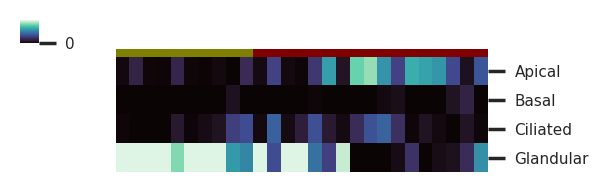

In [188]:
sns.set(font_scale=0.5)
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]

sns_plot = sns.clustermap(cibersort_sum.loc[['Apical', 'Basal', 'Ciliated','Glandular'],abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,1),cmap="mako",vmin = 0.0, vmax=0.8, cbar_kws={"ticks":[0,1]})
sns_plot.savefig("prop_cibersort.png")

In [106]:
autogenes_sum = proportions_nnls_norm.loc[['Apical_non','Basal_polyp','Ciliated','Endothelial','Fibroblast','Glandular','MastCell','Myeloid','PlasmaCell','TCell'],:]
autogenes_sum.index = ['Apical','Basal','Ciliated','Endothelial','Fibroblast','Glandular','MastCell','Myeloid','PlasmaCell','TCell']
autogenes_sum.loc['Basal'] = proportions_nnls_norm.loc['Basal_non'].astype(float)+proportions_nnls_norm.loc['Basal_polyp'].astype(float)
autogenes_sum.loc['Apical'] = proportions_nnls_norm.loc['Apical_non'].astype(float)+proportions_nnls_norm.loc['Apical_polyp'].astype(float)

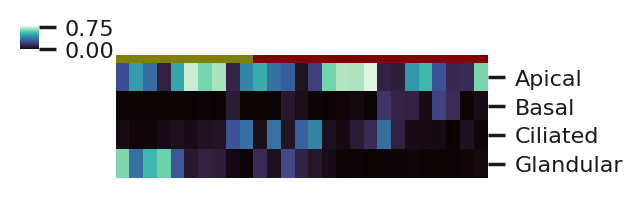

In [123]:
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]

sns_plot = sns.clustermap(autogenes_sum.loc[['Apical','Basal', 'Ciliated', 'Glandular'],abulks_proc.obs_names].astype(float), col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,1),cmap="mako",vmin = 0.0, vmax=0.8, cbar_kws={"ticks":[0,0.75]})
sns_plot.savefig("prop_autogenes.png")

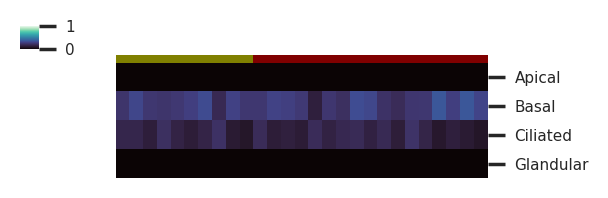

In [166]:
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]

sns_plot = sns.clustermap(music.loc[['Apical','Basal', 'Ciliated', 'Glandular'],abulks_proc.obs_names], col_colors=colors, col_cluster=False, row_cluster=False,
                        xticklabels=False, figsize=(3,1),cmap="mako",vmin = 0.0, vmax=1.0, cbar_kws={"ticks":[0,1]})
sns_plot.savefig("prop_music.png")

In [104]:
proportions_nnls_norm.to_csv('proportions_scraping_svr.csv')

AttributeError: 'AxesSubplot' object has no attribute 'right_ax'

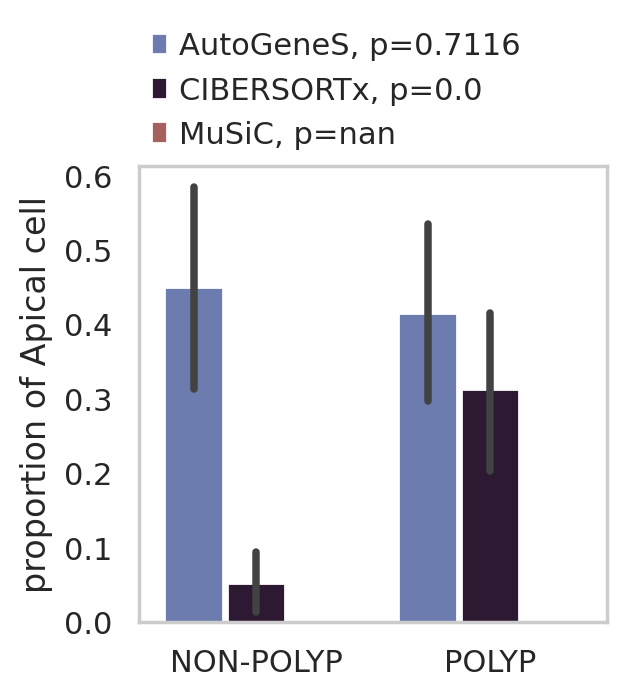

In [130]:
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid")

r_a,p_a = sci.stats.ttest_ind(autogenes_sum.loc["Apical",indices_pol], autogenes_sum.loc["Apical",indices_non], equal_var = False)
r_c,p_c = sci.stats.ttest_ind(cibersort_sum.loc["Apical",indices_pol], cibersort_sum.loc["Apical",indices_non], equal_var = False)
#r_m,p_m = sci.stats.ttest_ind(music.loc["Apical",indices_pol], music.loc["Apical",indices_non], equal_var = False)

#autogenes_sum.index = autogenes_sum.index.add_categories('method')
#cibersort.index = cibersort.index.add_categories('method')
#music.index = music.index.add_categories('method')
autogenes_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
cibersort_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
music.loc['sample',:] = proportions_nnls_norm.loc['sample',:]

cibersort_sum.loc['method'] = "CIBERSORTx, p="+str(round(p_c,3))
music.loc['method'] = "MuSiC, p=nan"#+str(round(p_m,3))
autogenes_sum.loc['method'] = "AutoGeneS, p="+str(round(p_a,4))
methods = pd.concat([autogenes_sum,cibersort_sum,music],axis=1)
tips = methods.T

fig, ax = plt.subplots(figsize=(3, 3))
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.figure(figsize=(5,5))
with sns.axes_style("whitegrid"):
    sns.barplot(x="sample", y="Apical", hue="method", data=tips,palette="twilight")
    #sns.swarmplot(x="sample", y="secretory cell", hue="method", data=tips, color="0", alpha=.95)
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .25)



plt.xlabel("")
#plt.title("p-value="+str(round(p,3)))
plt.ylabel("proportion of Apical cell")
#plt.axis('off')
ax.grid(False)
plt.legend(fontsize=10)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
            borderaxespad=0, frameon=False)
# Turns off grid on the secondary (right) Axis.
ax.right_ax(False)
plt.grid()
plt.ylim(ymin=0)

plt.show()

In [235]:
ax.get_figure().savefig('./apical_method.pdf', dpi=100)

AttributeError: 'AxesSubplot' object has no attribute 'right_ax'

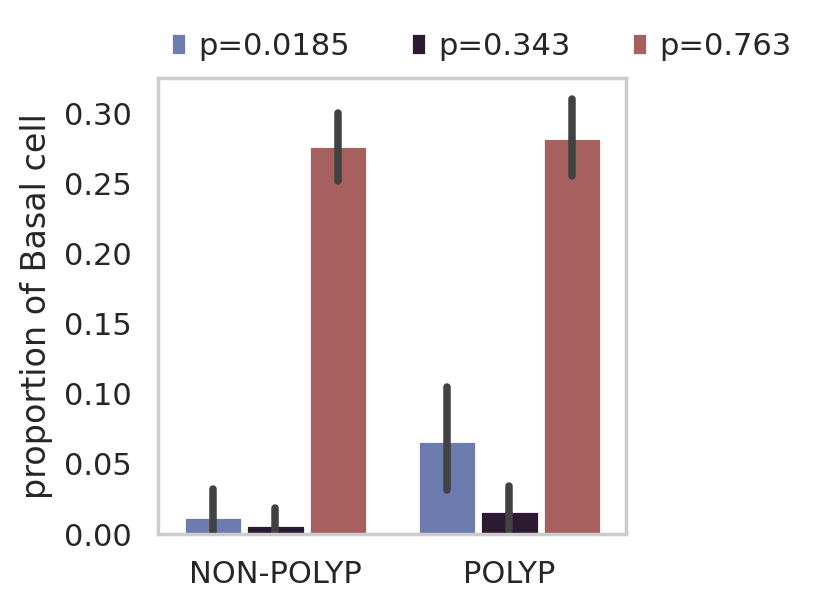

In [131]:
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid")

r_a,p_a = sci.stats.ttest_ind(autogenes_sum.loc["Basal",indices_pol], autogenes_sum.loc["Basal",indices_non], equal_var = False)
r_c,p_c = sci.stats.ttest_ind(cibersort_sum.loc["Basal",indices_pol], cibersort_sum.loc["Basal",indices_non], equal_var = False)
r_m,p_m = sci.stats.ttest_ind(music.loc["Basal",indices_pol], music.loc["Basal",indices_non], equal_var = False)

#autogenes_sum.index = autogenes_sum.index.add_categories('method')
#cibersort.index = cibersort.index.add_categories('method')
#music.index = music.index.add_categories('method')
autogenes_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
cibersort_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
music.loc['sample',:] = proportions_nnls_norm.loc['sample',:]

cibersort_sum.loc['method'] = "p="+str(round(p_c,3))
music.loc['method'] = "p="+str(round(p_m,3))
autogenes_sum.loc['method'] = "p="+str(round(p_a,4))
methods = pd.concat([autogenes_sum,cibersort_sum,music],axis=1)
tips = methods.T

fig, ax = plt.subplots(figsize=(3, 3))
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.figure(figsize=(5,5))
with sns.axes_style("whitegrid"):
    sns.barplot(x="sample", y="Basal", hue="method", data=tips,palette="twilight")
    #sns.swarmplot(x="sample", y="secretory cell", hue="method", data=tips, color="0", alpha=.95)
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .25)



plt.xlabel("")
#plt.title("p-value="+str(round(p,3)))
plt.ylabel("proportion of Basal cell")
#plt.axis('off')
ax.grid(False)
plt.legend(fontsize=10)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3,
            borderaxespad=0, frameon=False)
# Turns off grid on the secondary (right) Axis.
ax.right_ax(False)
plt.grid()
plt.ylim(ymin=0)

plt.show()

In [207]:
ax.get_figure().savefig('./basal_method.pdf', dpi=100)

AttributeError: 'AxesSubplot' object has no attribute 'right_ax'

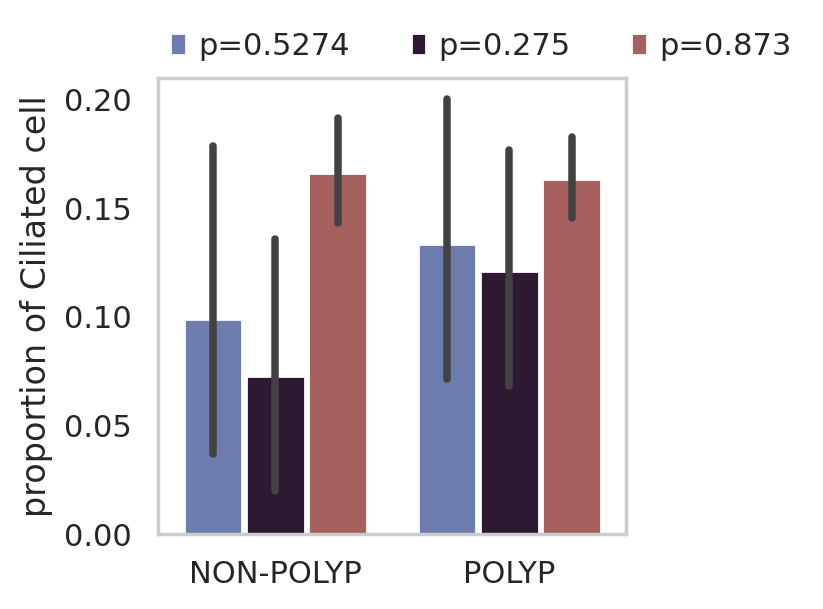

In [208]:
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid")

r_a,p_a = sci.stats.ttest_ind(autogenes_sum.loc["Ciliated",indices_pol], autogenes_sum.loc["Ciliated",indices_non], equal_var = False)
r_c,p_c = sci.stats.ttest_ind(cibersort_sum.loc["Ciliated",indices_pol], cibersort_sum.loc["Ciliated",indices_non], equal_var = False)
r_m,p_m = sci.stats.ttest_ind(music.loc["Ciliated",indices_pol], music.loc["Ciliated",indices_non], equal_var = False)

#autogenes_sum.index = autogenes_sum.index.add_categories('method')
#cibersort.index = cibersort.index.add_categories('method')
#music.index = music.index.add_categories('method')
autogenes_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
cibersort_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
music.loc['sample',:] = proportions_nnls_norm.loc['sample',:]

cibersort_sum.loc['method'] = "p="+str(round(p_c,3))
music.loc['method'] = "p="+str(round(p_m,3))
autogenes_sum.loc['method'] = "p="+str(round(p_a,4))
methods = pd.concat([autogenes_sum,cibersort_sum,music],axis=1)
tips = methods.T

fig, ax = plt.subplots(figsize=(3, 3))
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.figure(figsize=(5,5))
with sns.axes_style("whitegrid"):
    sns.barplot(x="sample", y="Ciliated", hue="method", data=tips,palette="twilight")
    #sns.swarmplot(x="sample", y="secretory cell", hue="method", data=tips, color="0", alpha=.95)
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .25)



plt.xlabel("")
#plt.title("p-value="+str(round(p,3)))
plt.ylabel("proportion of Ciliated cell")
#plt.axis('off')
ax.grid(False)
plt.legend(fontsize=10)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3,
            borderaxespad=0, frameon=False)
# Turns off grid on the secondary (right) Axis.
ax.right_ax(False)
plt.grid()
plt.ylim(ymin=0)

plt.show()

In [209]:
ax.get_figure().savefig('./ciliated_method.pdf', dpi=100)

AttributeError: 'AxesSubplot' object has no attribute 'right_ax'

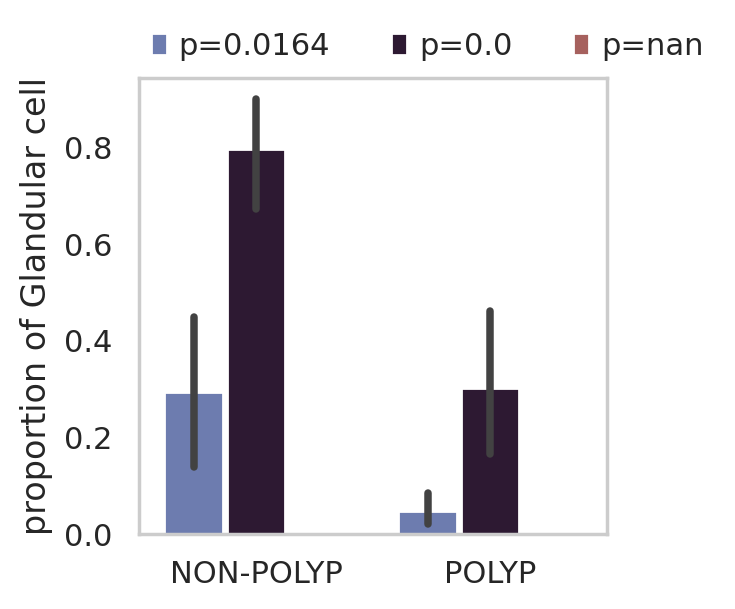

In [212]:
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid")

r_a,p_a = sci.stats.ttest_ind(autogenes_sum.loc["Glandular",indices_pol], autogenes_sum.loc["Glandular",indices_non], equal_var = False)
r_c,p_c = sci.stats.ttest_ind(cibersort_sum.loc["Glandular",indices_pol], cibersort_sum.loc["Glandular",indices_non], equal_var = False)
#r_m,p_m = sci.stats.ttest_ind(music.loc["Glandular",indices_pol], music.loc["Glandular",indices_non], equal_var = False)

#autogenes_sum.index = autogenes_sum.index.add_categories('method')
#cibersort.index = cibersort.index.add_categories('method')
#music.index = music.index.add_categories('method')
autogenes_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
cibersort_sum.loc['sample',:] = proportions_nnls_norm.loc['sample',:]
music.loc['sample',:] = proportions_nnls_norm.loc['sample',:]

cibersort_sum.loc['method'] = "p="+str(round(p_c,3))
music.loc['method'] = "p=nan"#+str(round(p_m,3))
autogenes_sum.loc['method'] = "p="+str(round(p_a,4))
methods = pd.concat([autogenes_sum,cibersort_sum,music],axis=1)
tips = methods.T

fig, ax = plt.subplots(figsize=(3, 3))
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.figure(figsize=(5,5))
with sns.axes_style("whitegrid"):
    sns.barplot(x="sample", y="Glandular", hue="method", data=tips,palette="twilight")
    #sns.swarmplot(x="sample", y="secretory cell", hue="method", data=tips, color="0", alpha=.95)
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .25)



plt.xlabel("")
#plt.title("p-value="+str(round(p,3)))
plt.ylabel("proportion of Glandular cell")
#plt.axis('off')
ax.grid(False)
plt.legend(fontsize=10)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3,
            borderaxespad=0, frameon=False)
# Turns off grid on the secondary (right) Axis.
ax.right_ax(False)
plt.grid()
plt.ylim(ymin=0)

plt.show()

In [213]:
ax.get_figure().savefig('./glandular_method.pdf', dpi=100)